In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,15)

from sklearn.preprocessing import OrdinalEncoder
from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
#import lightgbm as lgb

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Dropout, concatenate, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model

import tensorflow_addons as tfa

# Exploratory Data Analysis

## The introduction

Let's start this challange by inspecting our Dataset, regarding:
- Data Types
- Dataset Variables (Continuous/Discrete or Categorical)
- Size and Shape
- Missing and Dupicates Verification

In [2]:
df = pd.read_csv('accounting_dataset.csv')

In [3]:
df.head()

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533009 entries, 0 to 533008
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   BELNR   533009 non-null  int64  
 1   WAERS   533009 non-null  object 
 2   BUKRS   533009 non-null  object 
 3   KTOSL   533009 non-null  object 
 4   PRCTR   533009 non-null  object 
 5   BSCHL   533009 non-null  object 
 6   HKONT   533009 non-null  object 
 7   DMBTR   533009 non-null  float64
 8   WRBTR   533009 non-null  float64
 9   label   533009 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 40.7+ MB


In [5]:
df.shape

(533009, 10)

In [6]:
df.nunique()

BELNR    533009
WAERS        76
BUKRS       158
KTOSL        79
PRCTR       157
BSCHL        73
HKONT        73
DMBTR    528920
WRBTR    137575
label         3
dtype: int64

In [7]:
df = df.set_index('BELNR')
df.head()

,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
BELNR,,,,,,,,,
288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular


In [8]:
df.isna().sum().sum()

0

In [9]:
df[df.duplicated()]

,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
BELNR,,,,,,,,,
343047,C1,C12,C1,C11,A1,B1,10000000.0,0.0,regular
344725,C2,C25,C1,C11,A1,B1,10000000.0,0.0,regular
345311,C1,C14,C1,C12,A1,B1,10000000.0,0.0,regular
345086,C7,C77,C1,C13,A3,B1,10000000.0,0.0,regular
347881,C1,C17,C1,C10,A1,B1,10000000.0,0.0,regular
...,...,...,...,...,...,...,...,...,...
342985,C2,C21,C1,C15,A1,B1,10000000.0,0.0,regular
344297,C1,C18,C1,C15,A1,B1,10000000.0,0.0,regular
345812,C1,C15,C1,C17,A1,B1,10000000.0,0.0,regular


- Generous Dataset so far! There are neither missing or duplicates in it.
- There are not many variables (only 9 as said in the prior pdf)
- Several categorical feature and few continuous ones
- Half million records seems a great starting point! :D

## Data Understanding

Let's gain some knowledge about the data and the problem itselt.
This is one of the most crucial phases of the challenge.

### Continuous Variables

- statistical descriptives about the continuous data
- look for outliers
- check data distribution

In [10]:
df[['DMBTR','WRBTR']].describe().apply(lambda s: s.apply('{0:.2f}'.format))

,DMBTR,WRBTR
count,533009.00,533009.00
mean,922668.27,62260.00
std,2152290.90,811730.43
min,2.60,0.00
25%,215939.17,0.00
50%,486445.49,0.00
75%,975258.03,26316.00
max,92445540.62,59585064.51


#### Outliers Inspection

<AxesSubplot:>

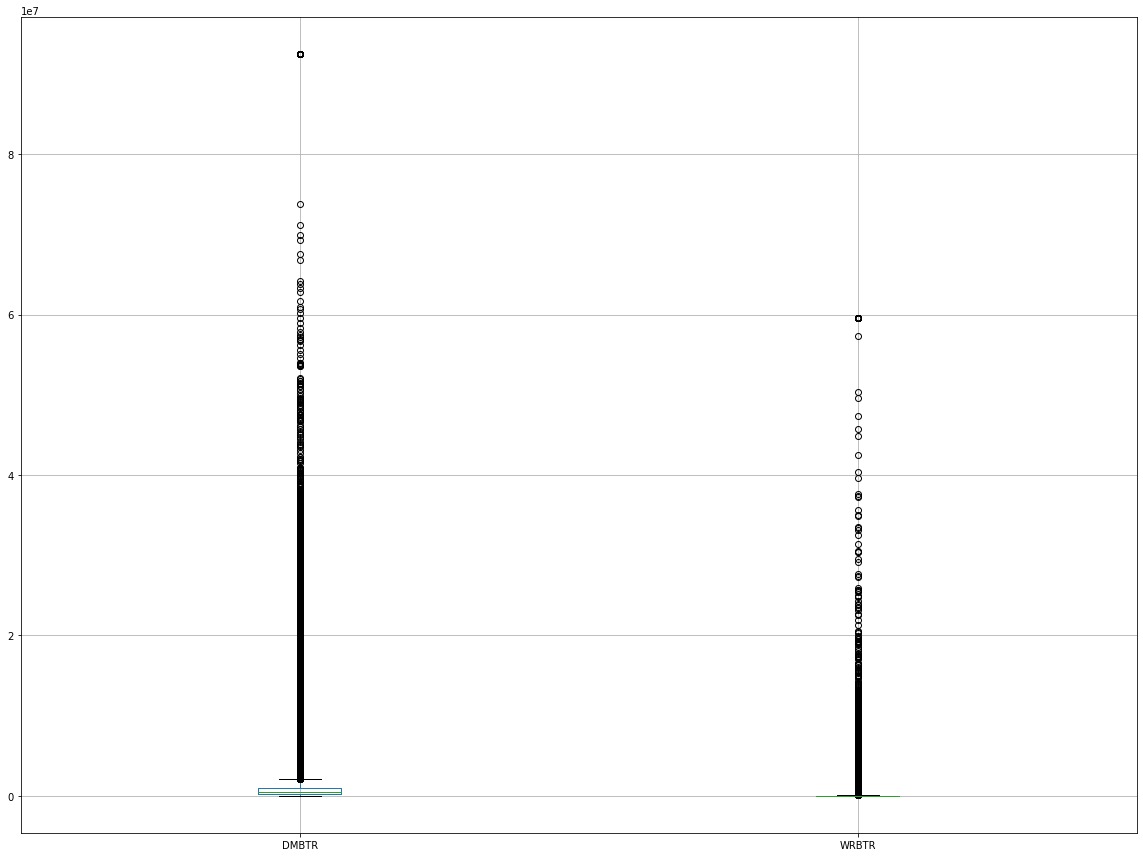

In [11]:
df.boxplot(column=['DMBTR', 'WRBTR']) 

There are several outliers. Outliers can have a significative impact on our models so it may be interesting solve them (instead of removing them at all), but first let's see if they represent anomalous values.

In [12]:
Q1 = df[['DMBTR','WRBTR']].quantile(0.25)
Q3 = df[['DMBTR','WRBTR']].quantile(0.75)
IQR = Q3 - Q1

In [13]:
# Let's count outliers for each continuous variable
((df[['DMBTR','WRBTR']] < (Q1 - 1.5 * IQR)) | (df[['DMBTR','WRBTR']] > (Q3 + 1.5 * IQR))).sum()

DMBTR    39835
WRBTR    79920
dtype: int64

In [14]:
outliers = ((df[['DMBTR','WRBTR']] < (Q1 - 1.5 * IQR)) | (df[['DMBTR','WRBTR']] > (Q3 + 1.5 * IQR)))

In [15]:
outliers_DMBTR = list(outliers[outliers['DMBTR'] == True].index)
outliers_WRBTR = list(outliers[outliers['WRBTR'] == True].index)

In [16]:
outliers_idx_lst = outliers_WRBTR.copy()

In [17]:
# Get list of all continuous variables outliers
count = 0

for outlier_index in outliers_DMBTR:
    if outlier_index not in outliers_WRBTR:
        outliers_idx_lst.append(outlier_index)
    else:
        count+1

In [18]:
len(outliers_WRBTR)

79920

In [19]:
# Are outliers anomalous values?
outl_df = df.iloc[outliers_idx_lst]
outl_df.head(20)

,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
BELNR,,,,,,,,,
91795,C9,C90,C6,C66,A2,B2,1351793.48,30768.00,regular
510445,C1,C12,C2,C21,A1,B3,1369527.27,105247.00,regular
172024,C1,C10,C1,C11,A1,B1,304211.75,0.00,regular
51402,C1,C18,C7,C71,A1,B2,862560.11,0.00,regular
394317,C1,C11,C1,C11,A1,B1,603182.13,0.00,regular
124041,C1,C17,C6,C60,A1,B2,823686.20,0.00,regular
435746,C1,C17,C1,C14,A1,B1,1295677.63,11283.00,regular
188270,C1,C19,C3,C38,A1,B2,202287.92,75808.89,regular
210494,C1,C10,C1,C11,A1,B1,209619.81,0.00,regular


In [20]:
outl_df.shape

(113251, 9)

In [21]:
sum(df.iloc[outliers_idx_lst]['label'] == 'regular')

113236

In [22]:
sum((df.iloc[outliers_idx_lst]['label'] == 'global'))

11

In [23]:
outl_df[outl_df['label']=='global']

,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
BELNR,,,,,,,,,
532974,U94,K13,K84,U04,N56,N94,9.244550e+07,5.958504e+07,global
532929,E59,R76,D30,M02,D16,B35,9.244551e+07,5.958504e+07,global
532961,G38,L49,J67,O92,L36,K45,9.244552e+07,5.958503e+07,global
532971,D48,L43,R89,B72,Y59,D00,9.244553e+07,5.958505e+07,global
532917,J82,Q22,P32,Z74,Y19,K27,9.244553e+07,5.958504e+07,global
532930,G92,W69,K78,J13,W62,S49,9.244554e+07,5.958505e+07,global
532941,E15,M55,V86,X23,J72,R19,9.244551e+07,5.958506e+07,global
532958,Q82,S54,J53,T46,Y42,S06,9.244553e+07,5.958503e+07,global
532910,P36,V48,Z17,J68,Q50,J62,9.244554e+07,5.958504e+07,global


In [24]:
sum((df.iloc[outliers_idx_lst]['label'] == 'local'))

4

In [25]:
outl_df[outl_df['label']=='local']

,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
BELNR,,,,,,,,,
532991,C1,C11,C1,C91,A1,B1,910668.887465,54440.856583,local
533009,C1,C11,C1,C32,A1,B1,910658.458544,54432.742656,local
532984,C1,C11,C1,C68,A1,B1,910648.636111,54442.618111,local
532993,C1,C11,C1,C70,A1,B1,910676.587040,54441.755167,local


Not many anomalous values as outliers.
- Seems like an highly unbalanced dataset (We'll check that later)
- All of the global anomalies have 'anomalous' values of amount values
- No local anomalies with outliers

Time to check de distributions! (We will probably have long tails due to high valued outliers)

<AxesSubplot:ylabel='Frequency'>

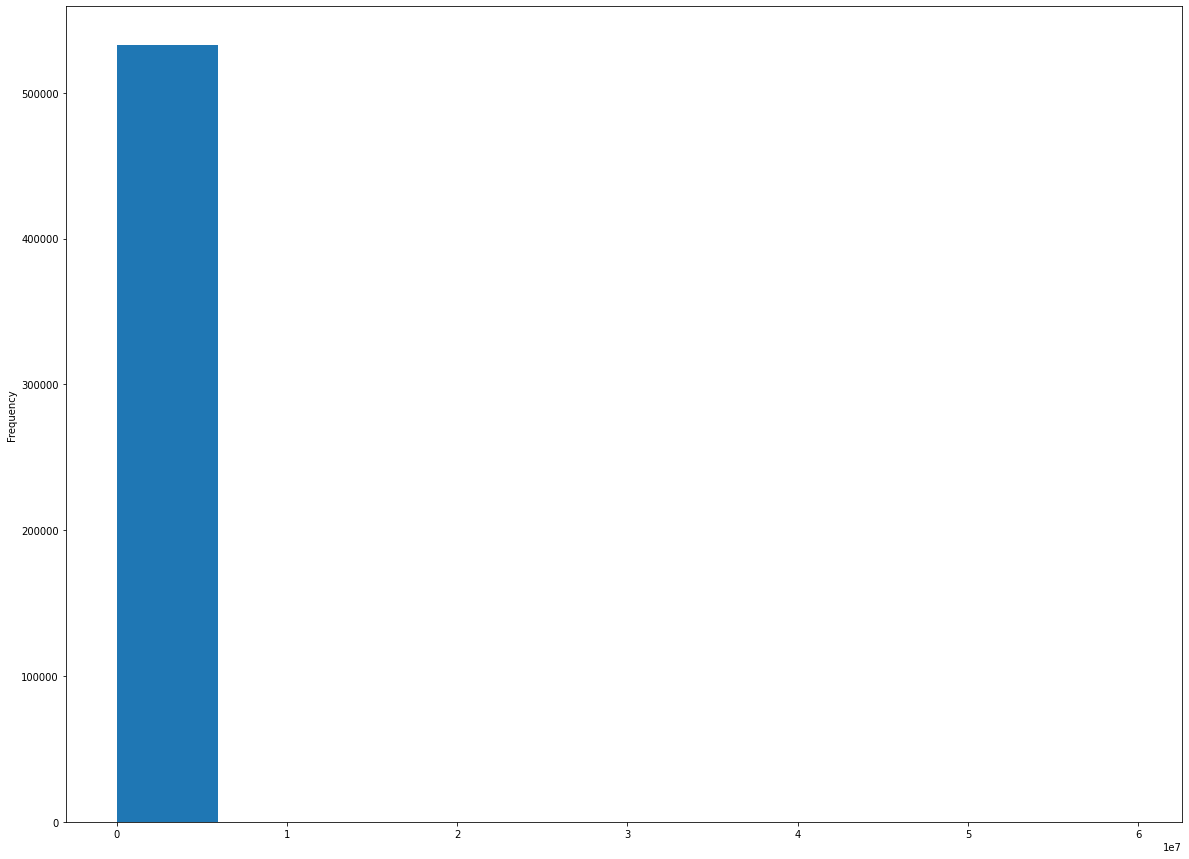

In [26]:
df['WRBTR'].plot.hist()
# sns.histplot(data=df, x='WRBTR')

<AxesSubplot:ylabel='Frequency'>

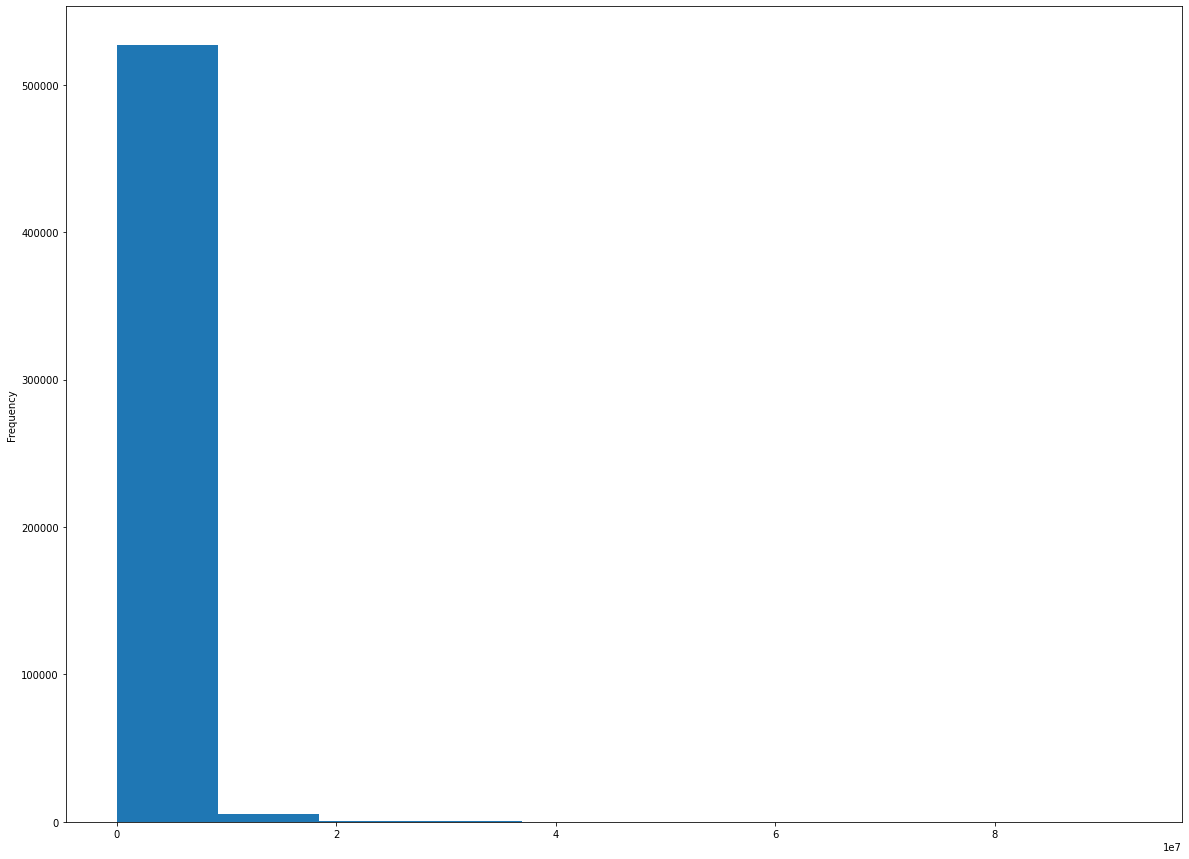

In [27]:
df['DMBTR'].plot.hist()
# sns.histplot(data=df, x='DMBTR')

Long tails in the distributions, as expected due to high outlier values present in the dataset. Seems like log normal distributions. What if we solve our outliers by the 1st and the 3rd quantile (values lower than the 1st quantile and higher than the 3rd quantile will be replace by them as min and max values)?

In [28]:
df_without_outliers = df[['DMBTR','WRBTR']].copy()

lower_vals = (df_without_outliers < (Q1 - (1.5 * IQR)))
upper_vals = (df_without_outliers > (Q3 + (1.5 * IQR)))

df_without_outliers = df_without_outliers.mask(lower_vals, Q1, axis=1)
df_without_outliers = df_without_outliers.mask(upper_vals, Q3, axis=1)
df_without_outliers.shape

(533009, 2)

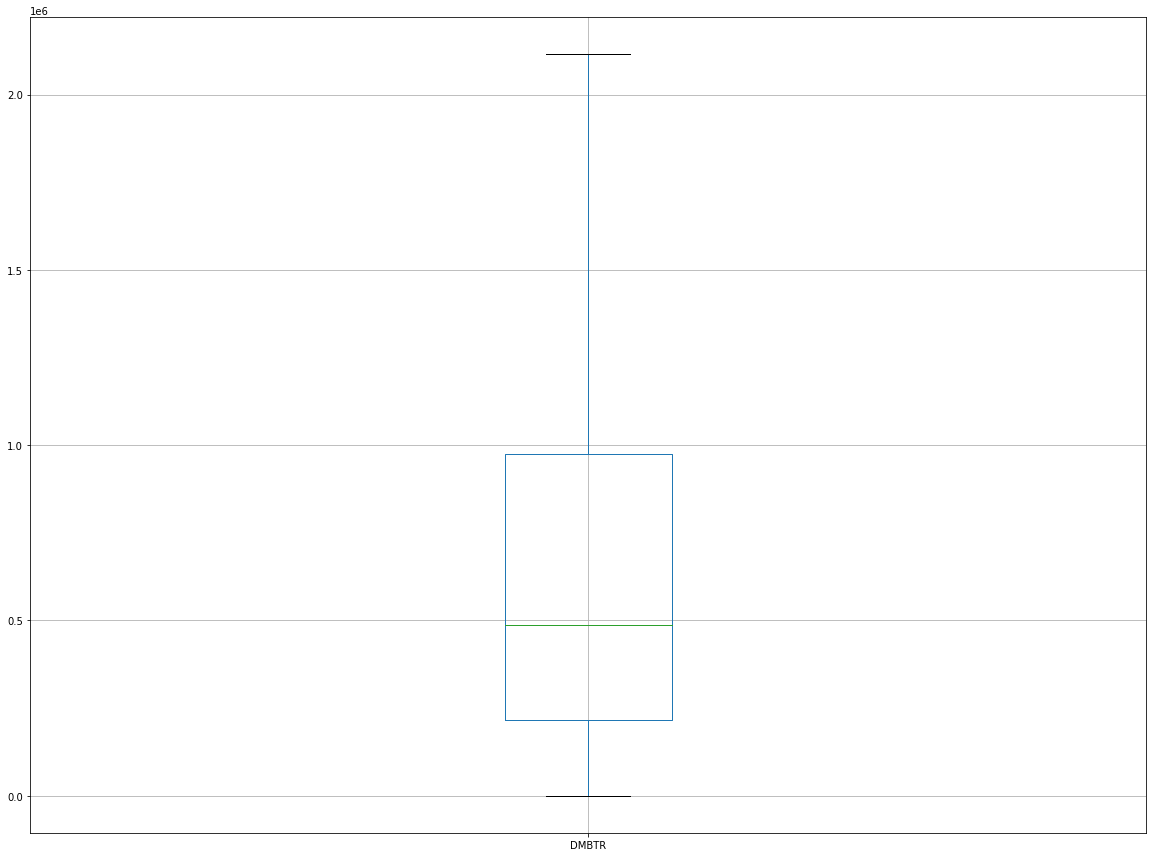

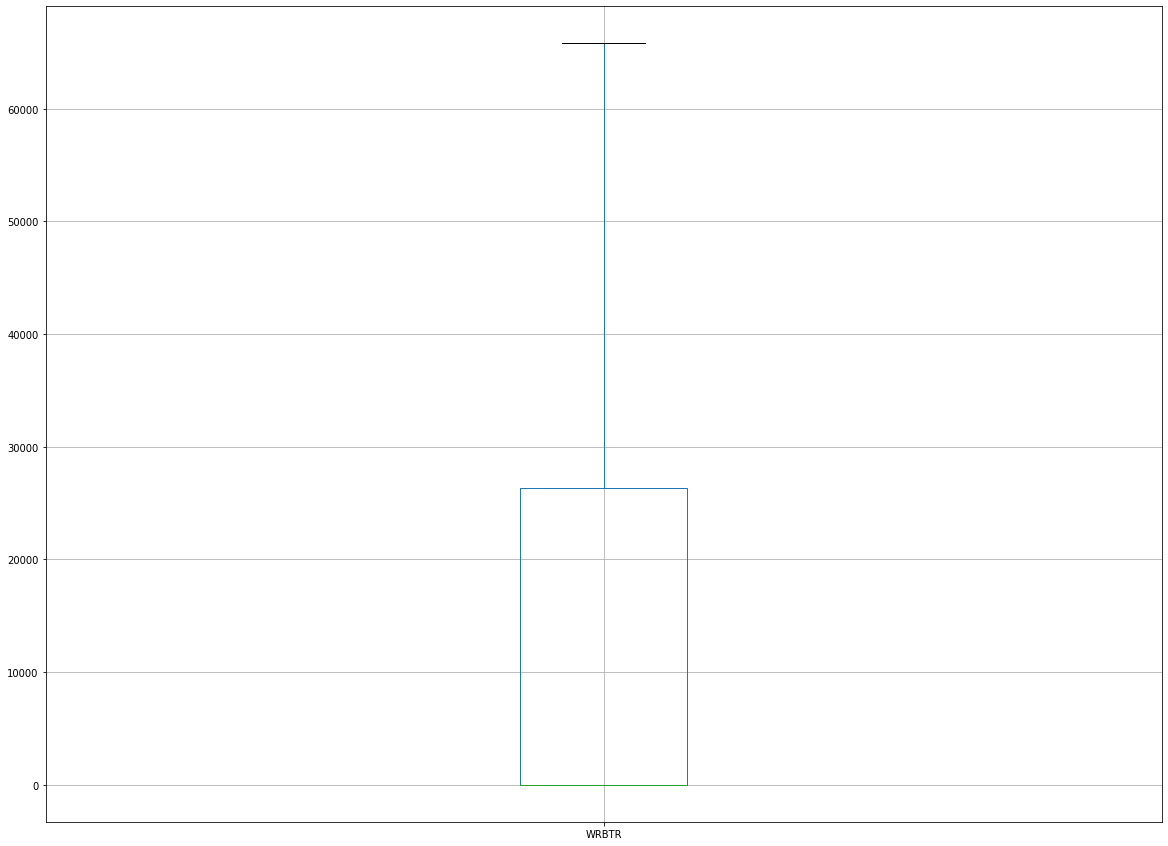

In [29]:
df_without_outliers.boxplot(column=['DMBTR'])
plt.show()
df_without_outliers.boxplot(column=['WRBTR'])
plt.show()

Let's check the distributions again now, this time with no outliers

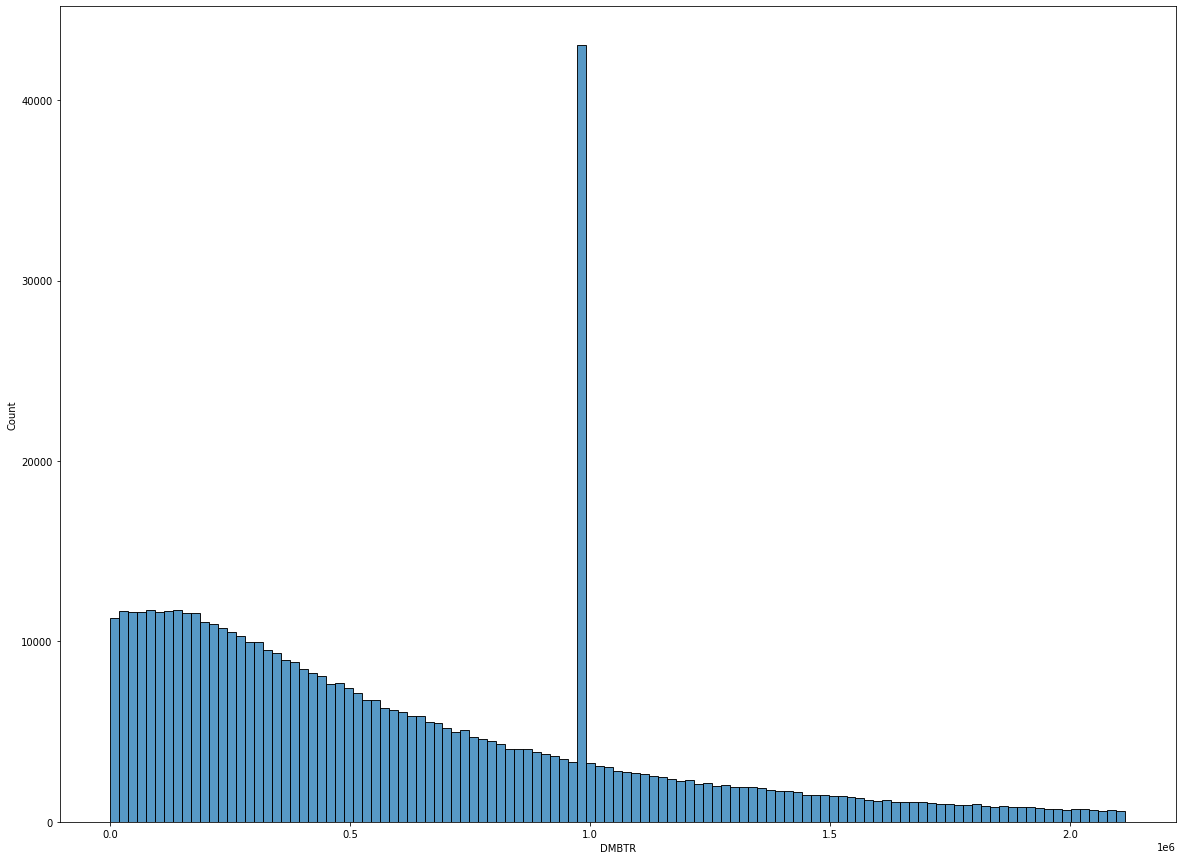

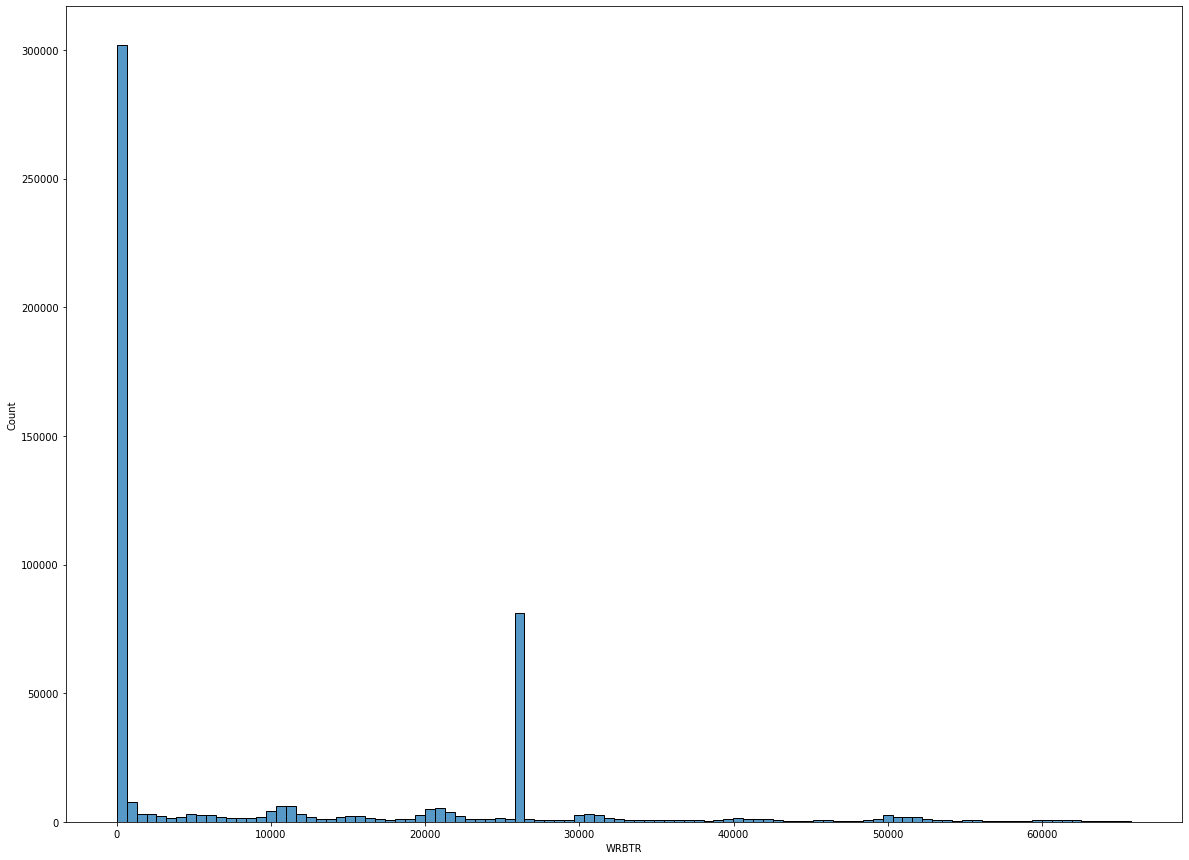

In [30]:
for col in df_without_outliers.columns:
    sns.histplot(data=df_without_outliers, x=col)
    plt.show()

They still have large kurtosis. Let's try a log transform to take care of those long tails.

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<AxesSubplot:xlabel='WRBTR', ylabel='Count'>

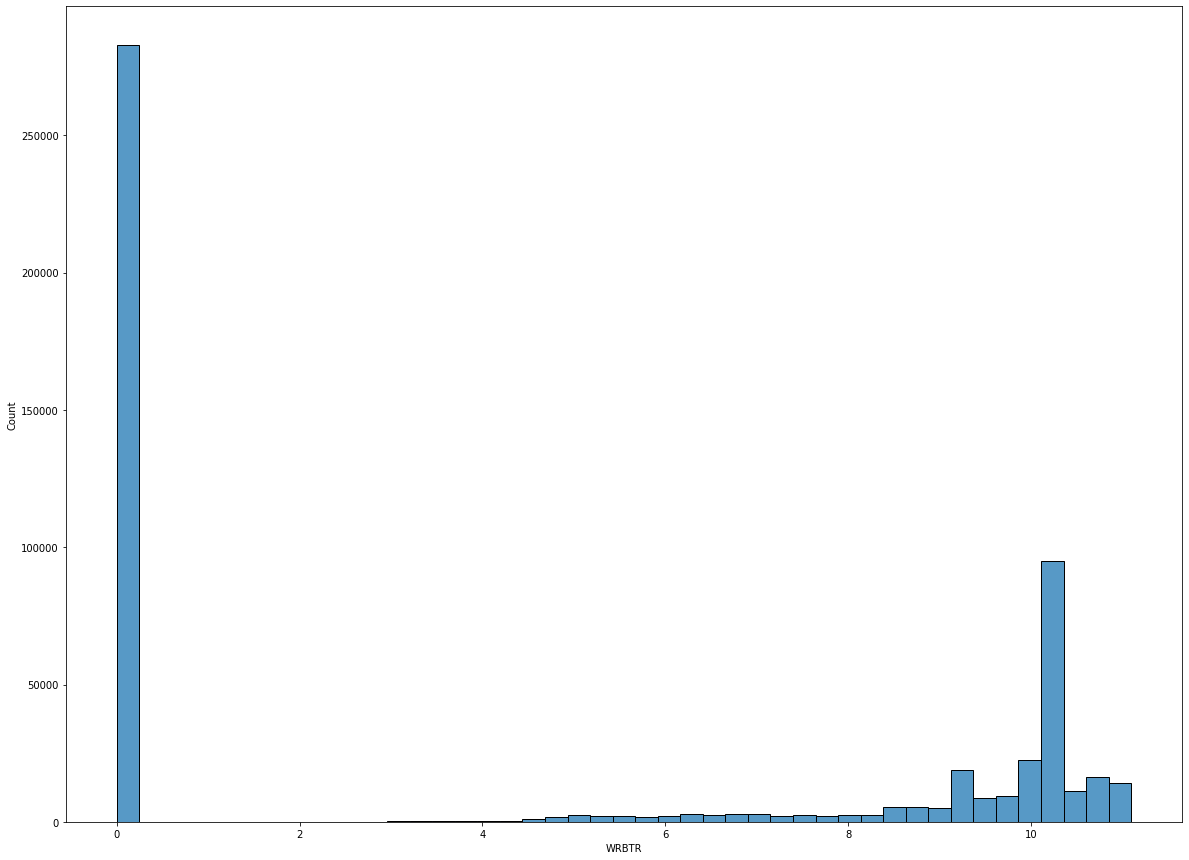

In [31]:
log_transform_WRBTR = np.log(df_without_outliers[['WRBTR']])
log_transform_WRBTR.replace([np.inf, -np.inf], 0, inplace=True)
# log_transform_WRBTR.plot.hist()
sns.histplot(data=log_transform_WRBTR, x='WRBTR')

<AxesSubplot:xlabel='DMBTR', ylabel='Count'>

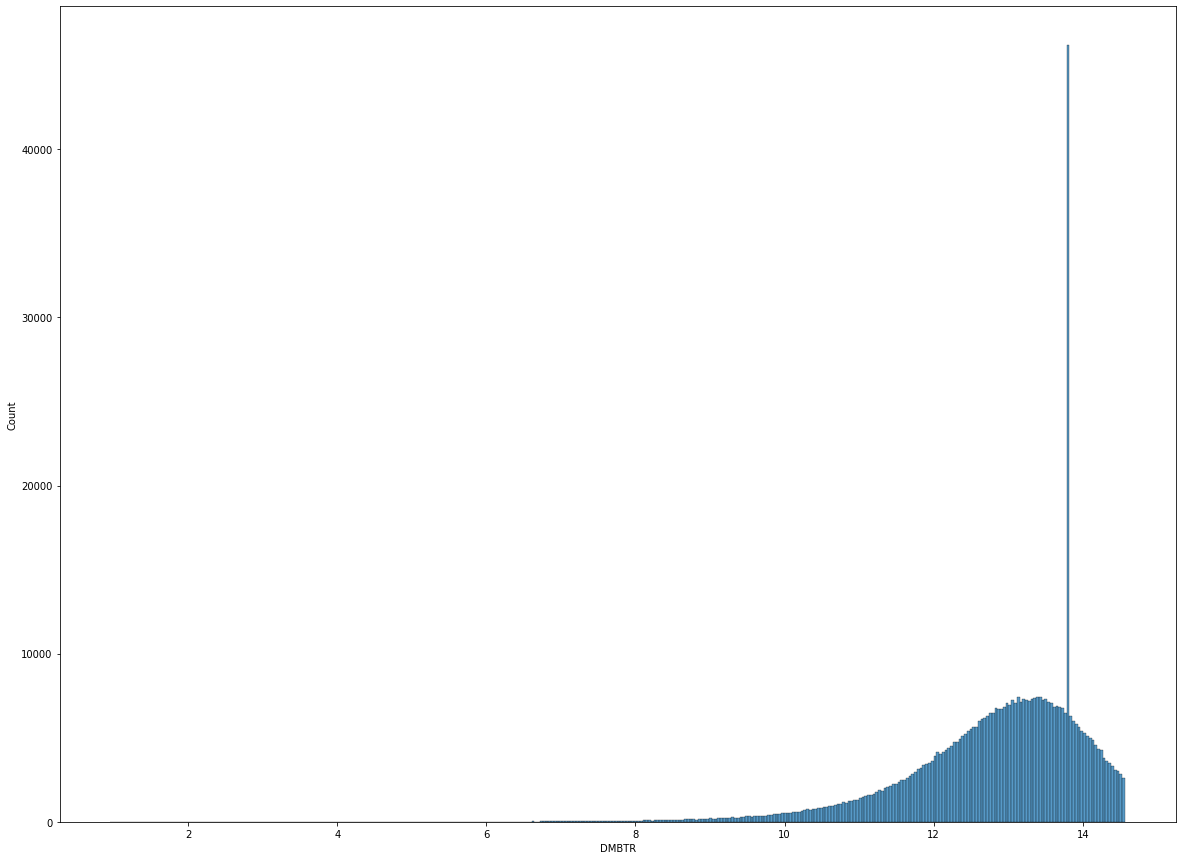

In [32]:
log_transform_DMBTR = np.log(df_without_outliers[['DMBTR']])
log_transform_DMBTR.replace([np.inf, -np.inf], 0, inplace=True)
# log_transform_DMBTR.plot.hist()
sns.histplot(data=log_transform_DMBTR, x='DMBTR')

A log transform improved a bit the normal distribution (Data seem to be more normally distributed). But we can still watch evidences of non linearities in our data. Let's try them both on the Modeling Phase (transformed and not transformed) to see if we have some improvements.
What about the correlation between them?

In [33]:
transformed_df = log_transform_DMBTR.join(log_transform_WRBTR, on='BELNR')

In [34]:
transformed_df.head()

,DMBTR,WRBTR
BELNR,,
288203,12.546037,0.000000
324441,11.774186,10.177932
133537,13.772043,10.177932
331521,13.790457,10.267366
375333,13.721765,5.846439


In [35]:
transformed_df[['DMBTR','WRBTR']].corr()

,DMBTR,WRBTR
DMBTR,1.000000,0.036651
WRBTR,0.036651,1.000000


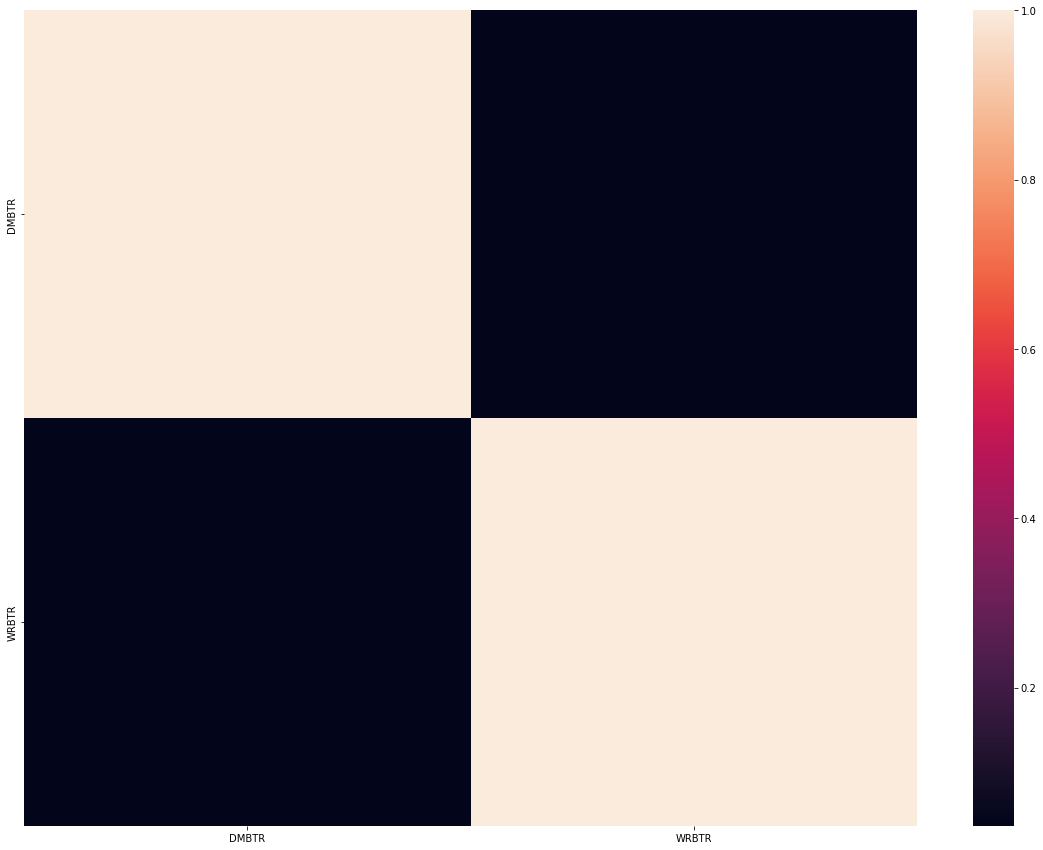

In [36]:
ax = sns.heatmap(transformed_df[['DMBTR','WRBTR']].corr())

The continuous features are not correlated at all. That's actually a good thing since multicolinearity is a problem for several ML Models.
Now it's time to inspect the categorical features!

### Categorical Variables 

Let's inspect categorical features

In [37]:
categorical_variables = df[['WAERS','BUKRS','KTOSL','PRCTR','BSCHL','HKONT']]

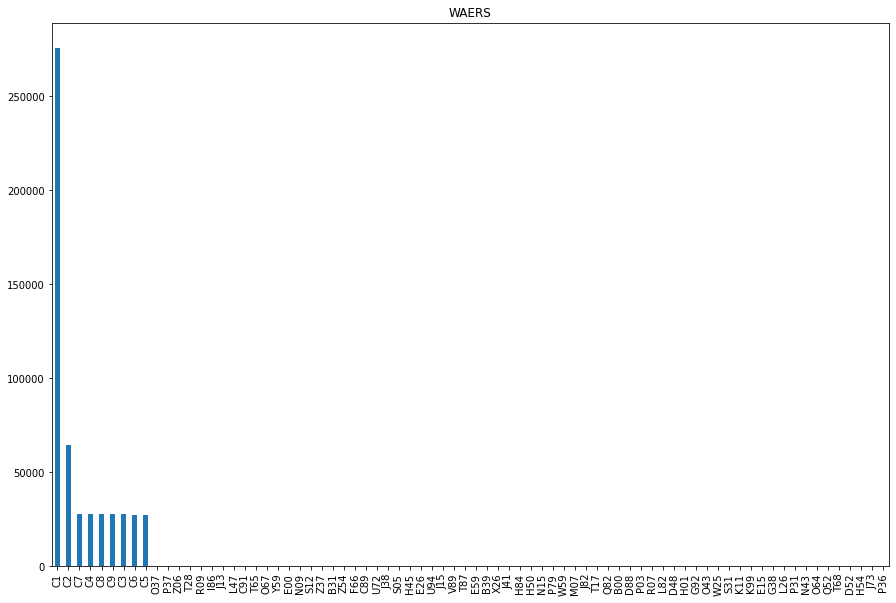

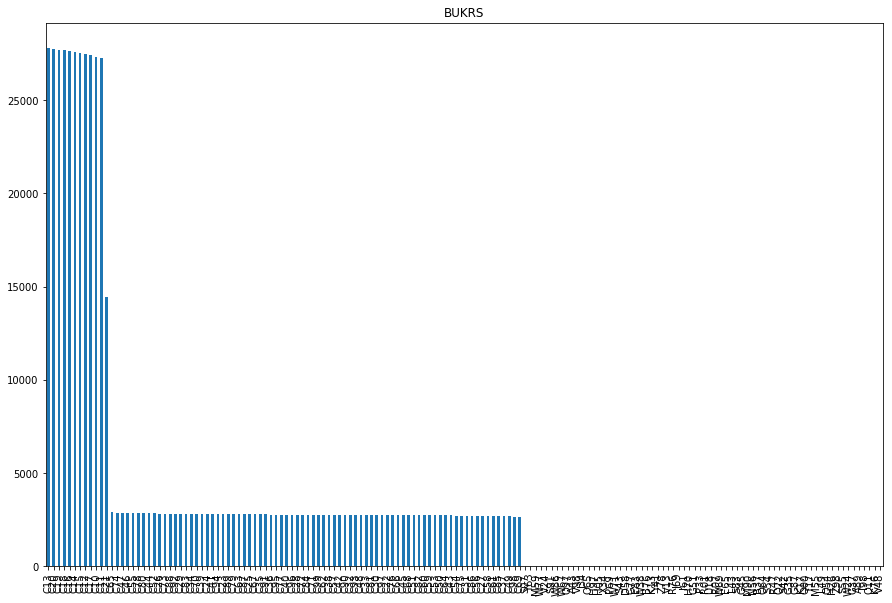

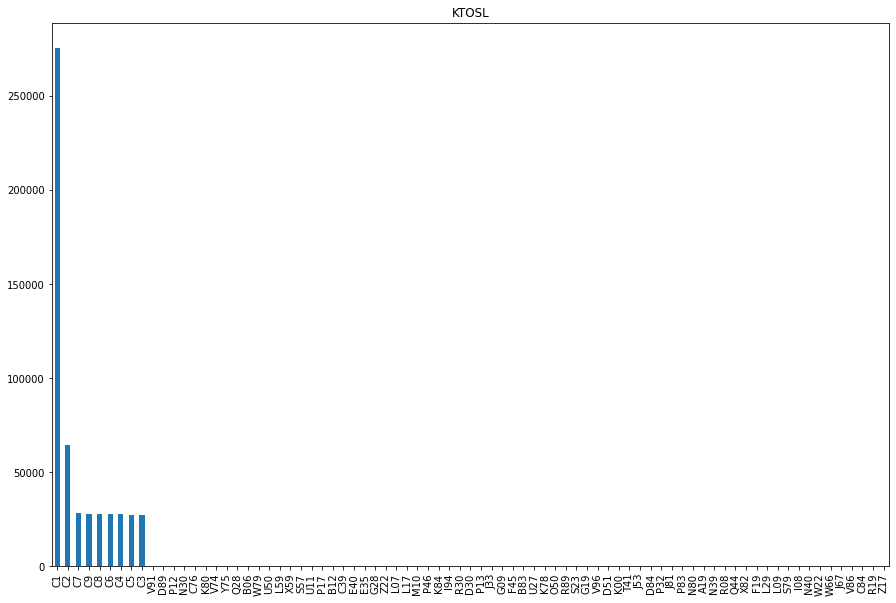

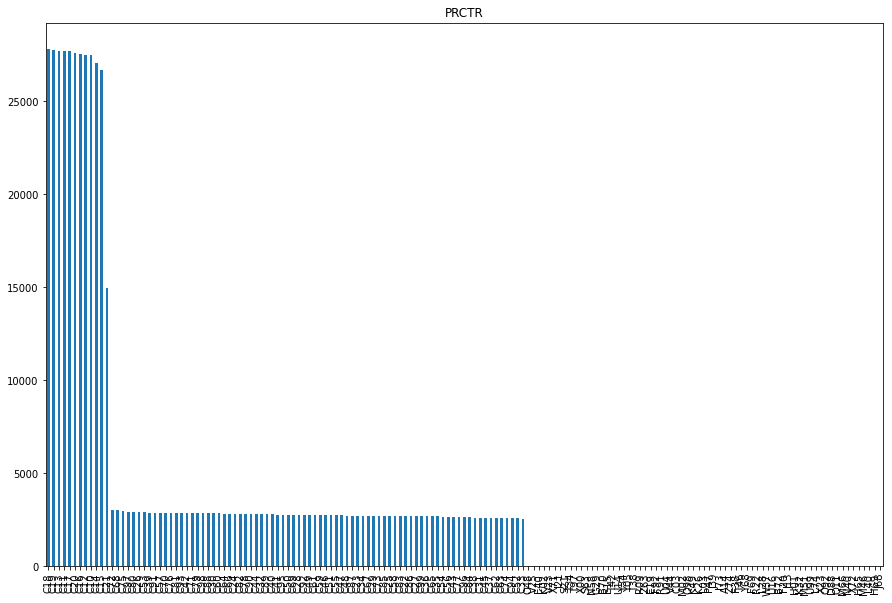

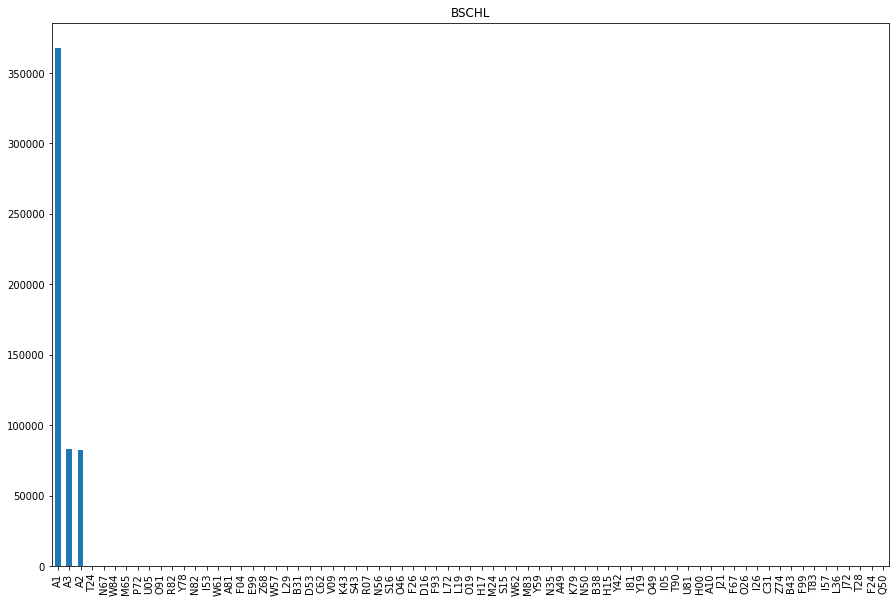

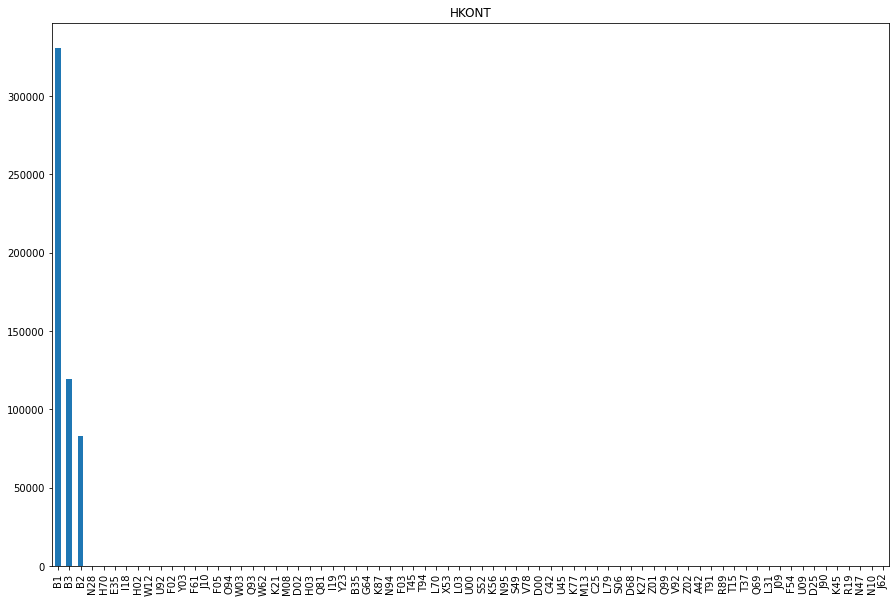

In [38]:
frequencies = []
for col in categorical_variables.columns:
    categorical_variables[col].value_counts().plot(kind='bar',figsize=(15, 10))
    plt.title(col)
    plt.show()

Several Categorical Variables values turns the encoding part a bit tricky. Let's inspect the impact they have on the target variable.

### Target (Label)

I like to gain some knowledge about the dataset, analysing the labels. This step helps to understand and distinguish an anomalous behaviour from a regular one.
For this step I ask myself: 
   - What causes na anomaly?
   - What are the variables that have a major impact on anomalies?
       - Do they impact directly the decision? Do they need any externel contribute from others to cause an anomaly?
   - What should I expect (according to the data that I have) to be a regular behaviour?

In [39]:
df['label'].value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

Highly Unbalanced!

In [40]:
anomaly_df = df[(df['label']=='regular')]
anomaly_df.head(20)

,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
BELNR,,,,,,,,,
288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular


In [41]:
# Let's inspect some anomalies
anomaly_df = df[(df['label']=='global') | (df['label']=='local')]
anomaly_df.head(20)

,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
BELNR,,,,,,,,,
532980,C1,C20,C1,C18,A1,B1,9.106583e+05,5.444984e+04,local
532989,C1,C11,C1,C53,A1,B1,9.106530e+05,5.443921e+04,local
532942,W59,C13,P83,I73,I05,Q99,9.244552e+07,5.958504e+07,global
532991,C1,C11,C1,C91,A1,B1,9.106689e+05,5.444086e+04,local
533003,C1,C11,C1,C64,A1,B1,9.106316e+05,5.444328e+04,local
532967,M07,S42,J81,A14,O49,Z01,9.244553e+07,5.958503e+07,global
532917,J82,Q22,P32,Z74,Y19,K27,9.244553e+07,5.958504e+07,global
532923,T17,R47,D84,F38,I81,D68,9.244552e+07,5.958505e+07,global
532998,C1,C11,C1,C79,A1,B1,9.106504e+05,5.443506e+04,local


Very heterogeneous categorical results for anomalies while, homogeneous for regular label values.

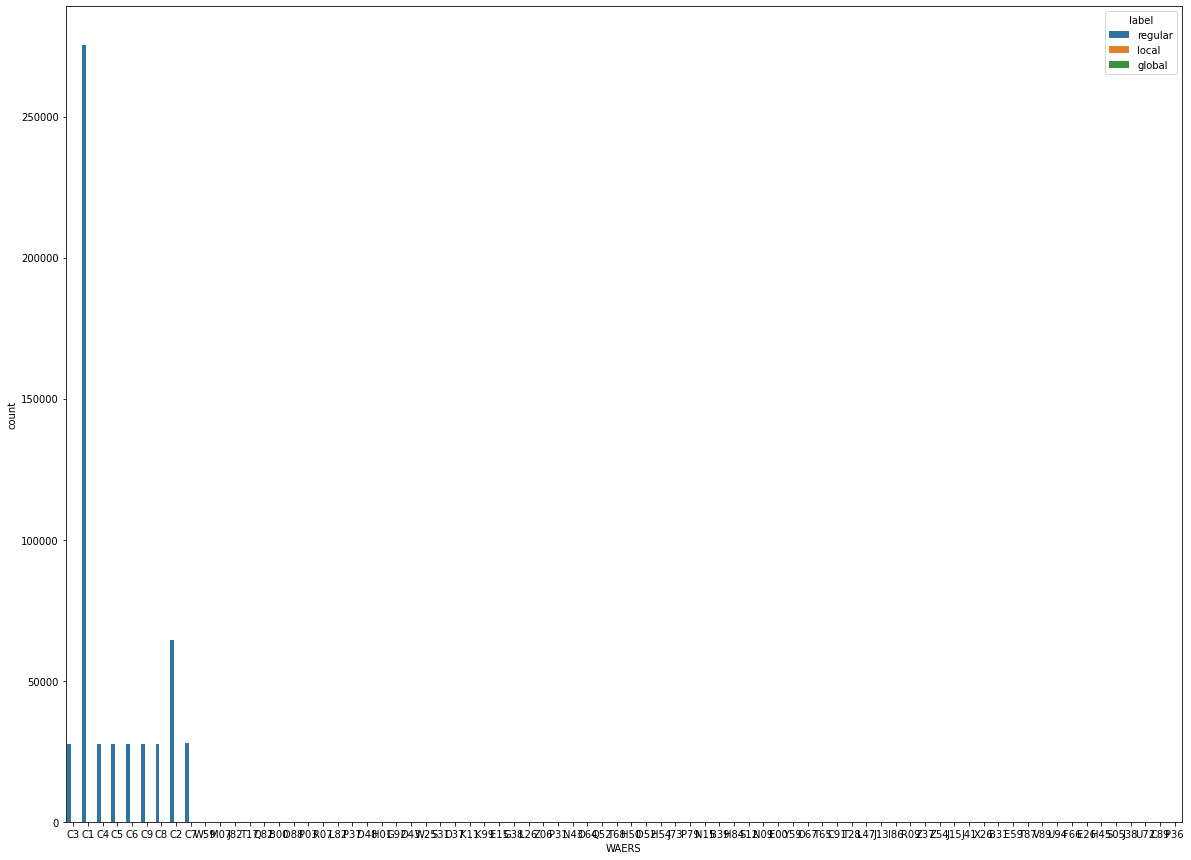

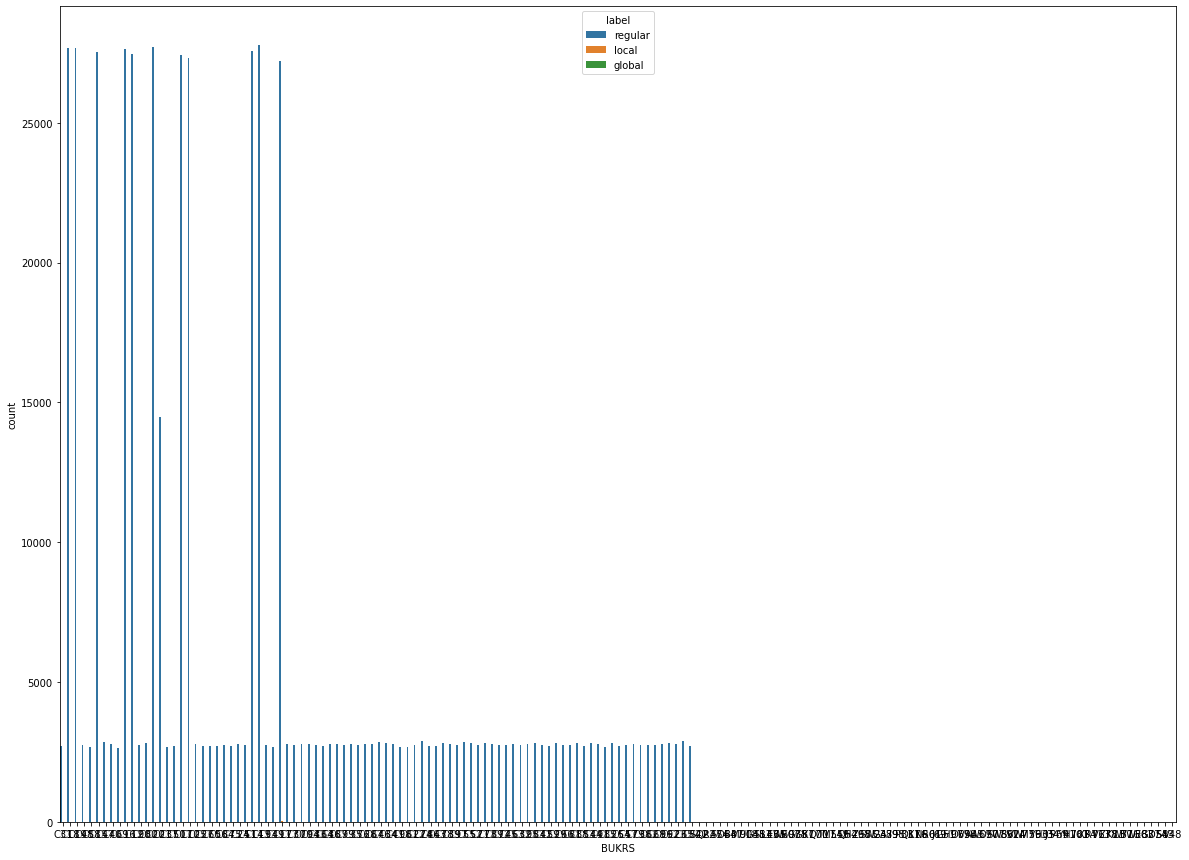

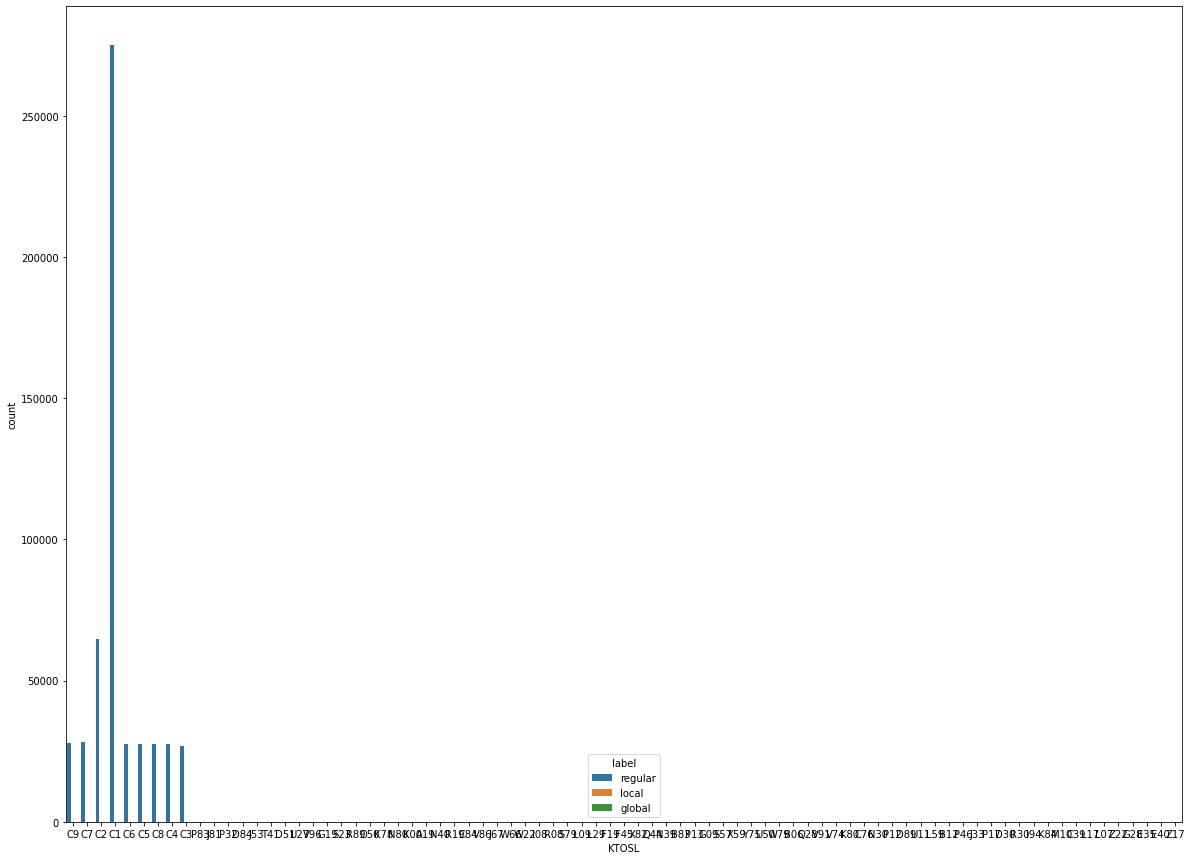

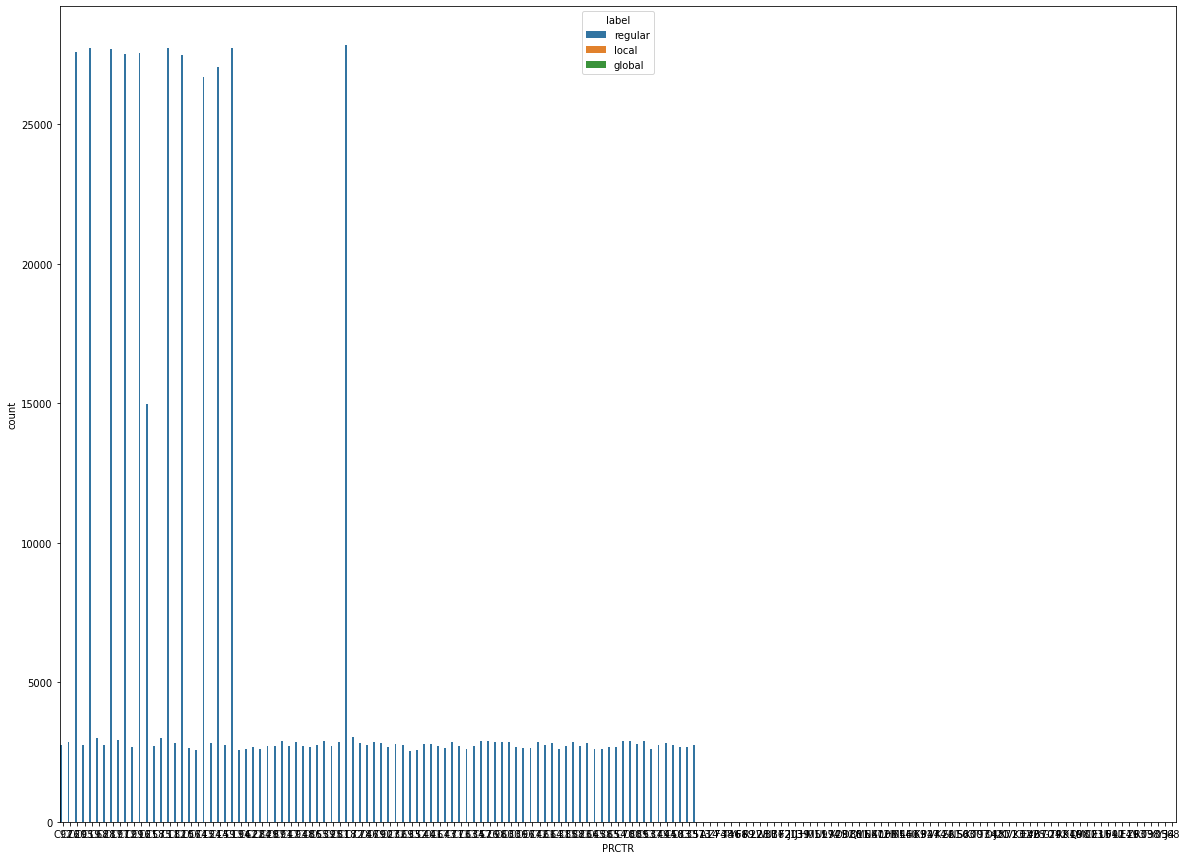

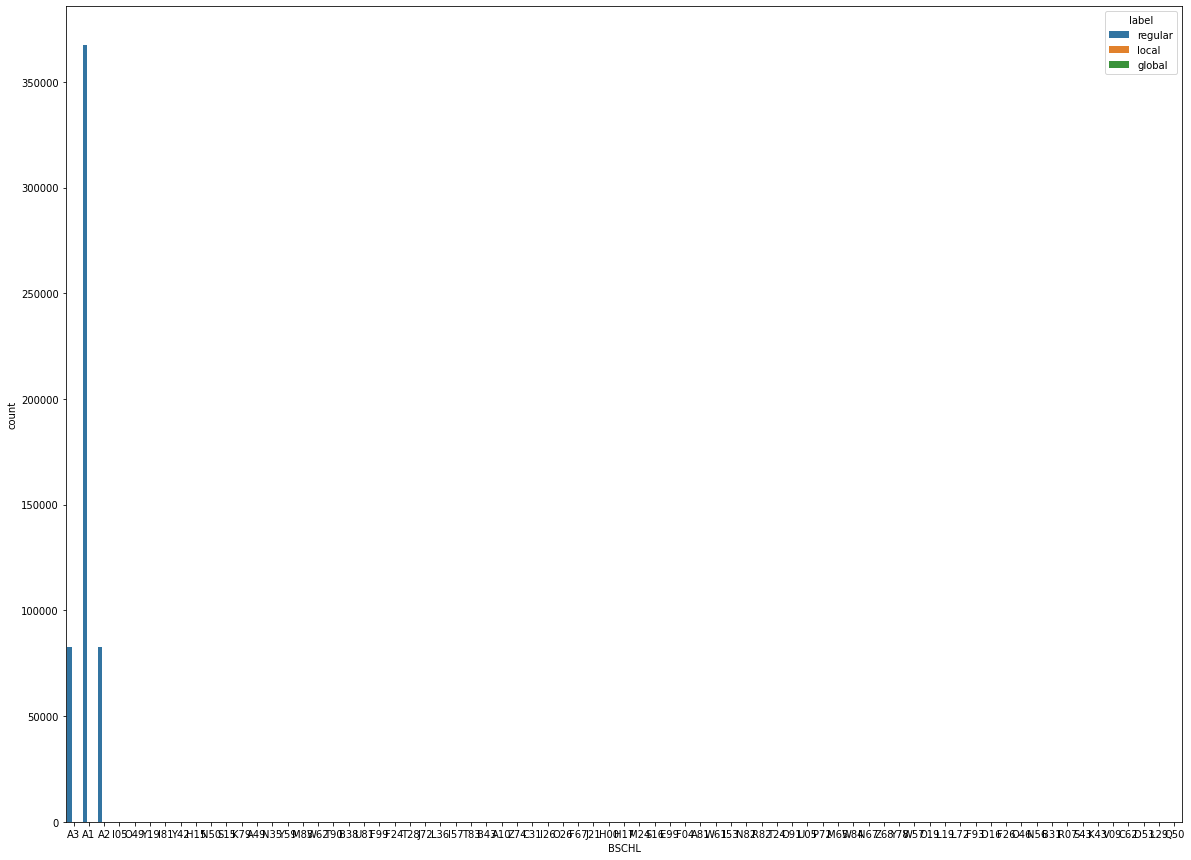

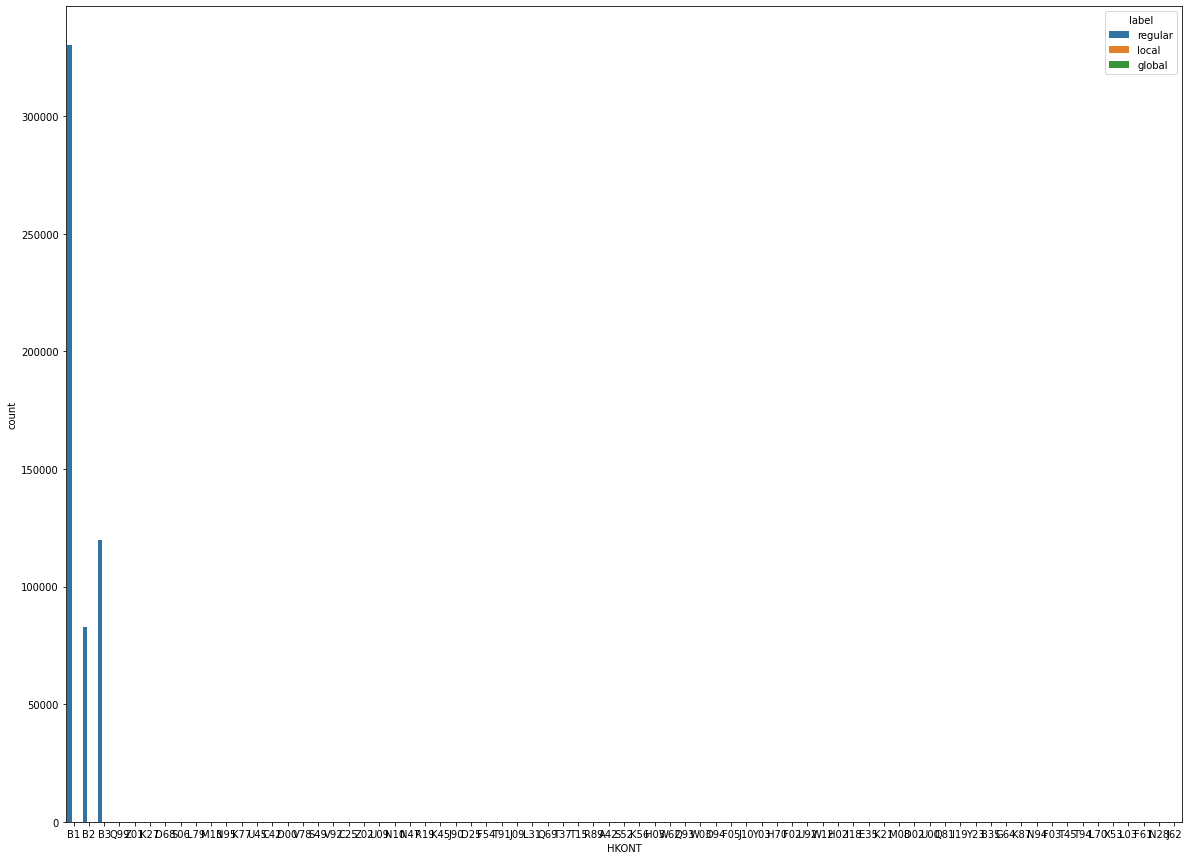

In [42]:
for col in categorical_variables.columns:
    sns.countplot(x=col, hue='label', data=df)
    plt.show()

There are so few anomalies that I can't even see them in these representations. This dataset is totally unbalanced. Let's get the big picture of the anomalies only. :D

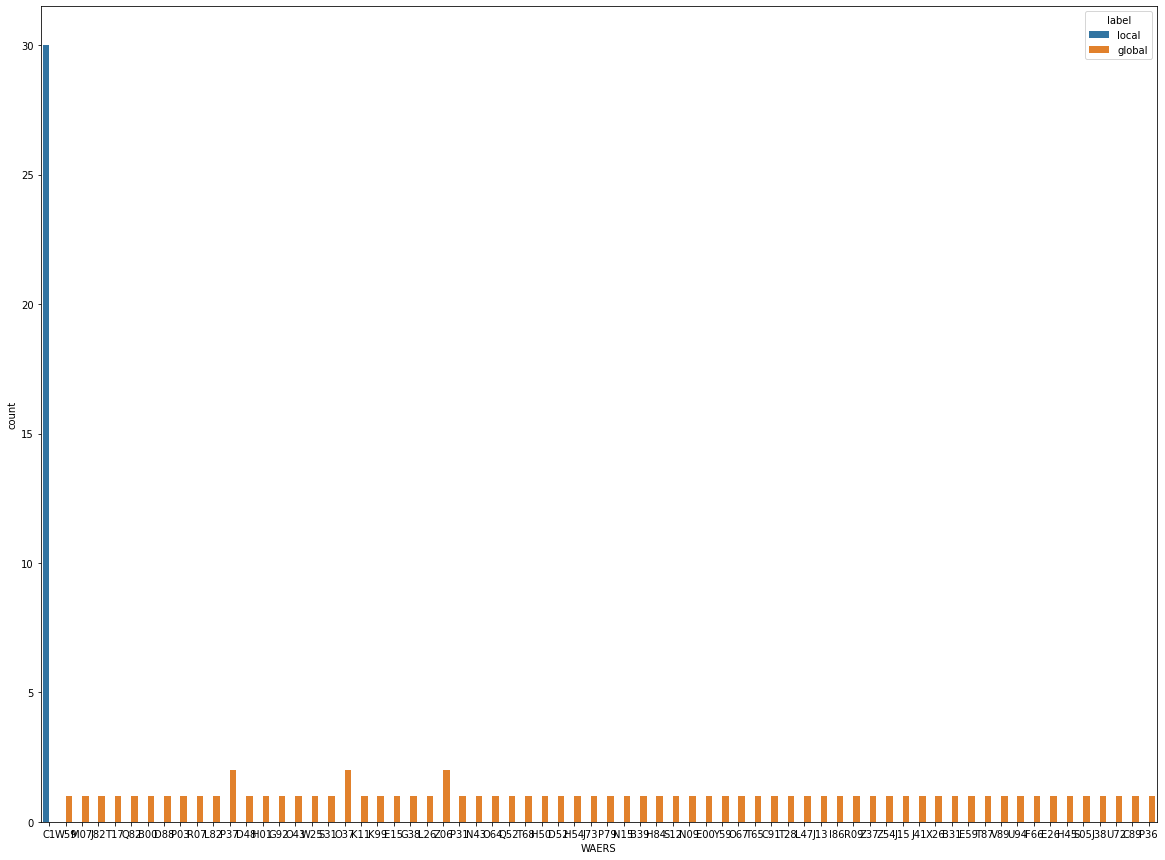

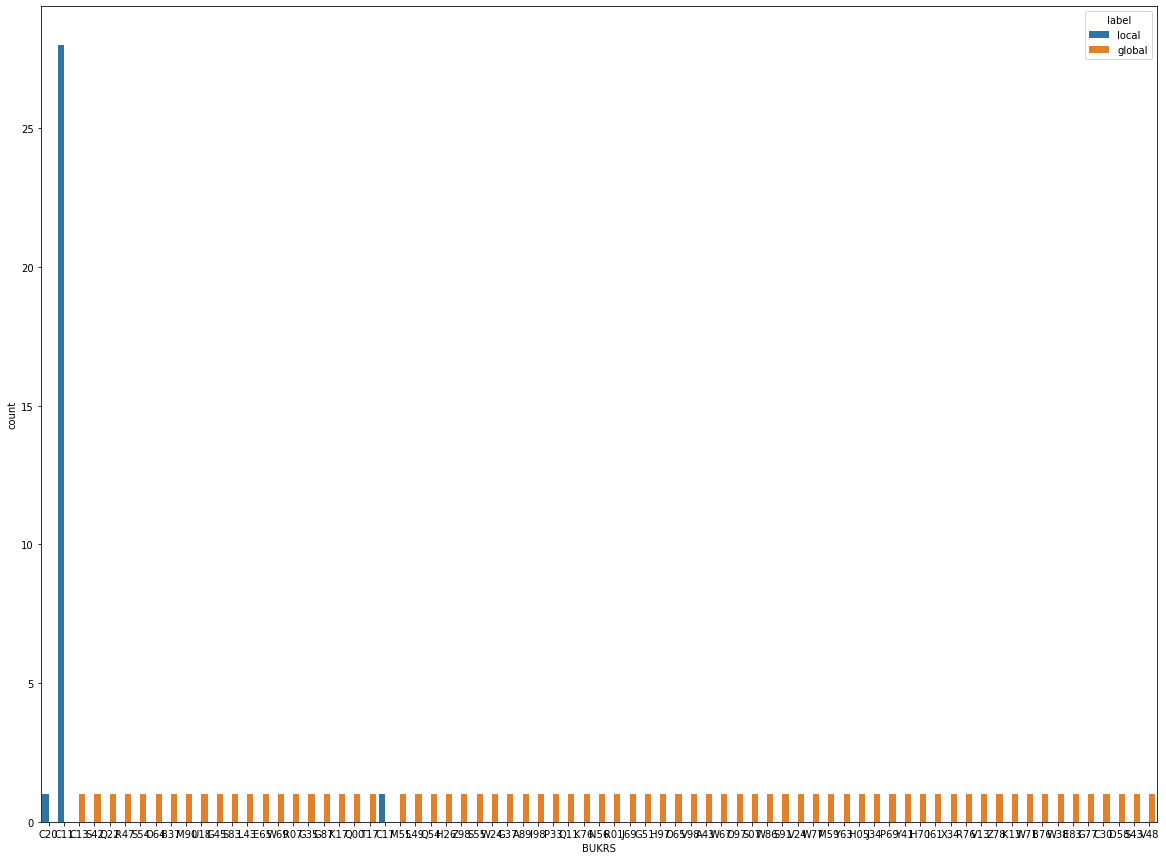

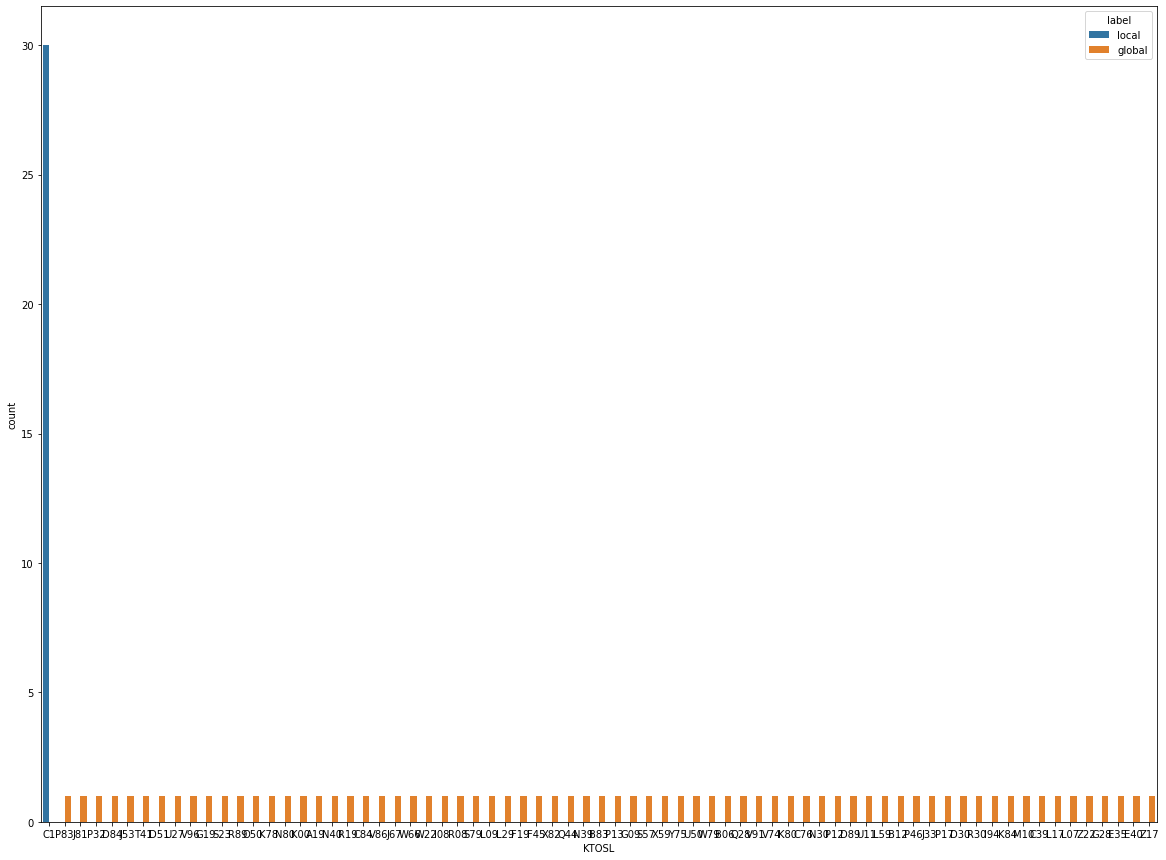

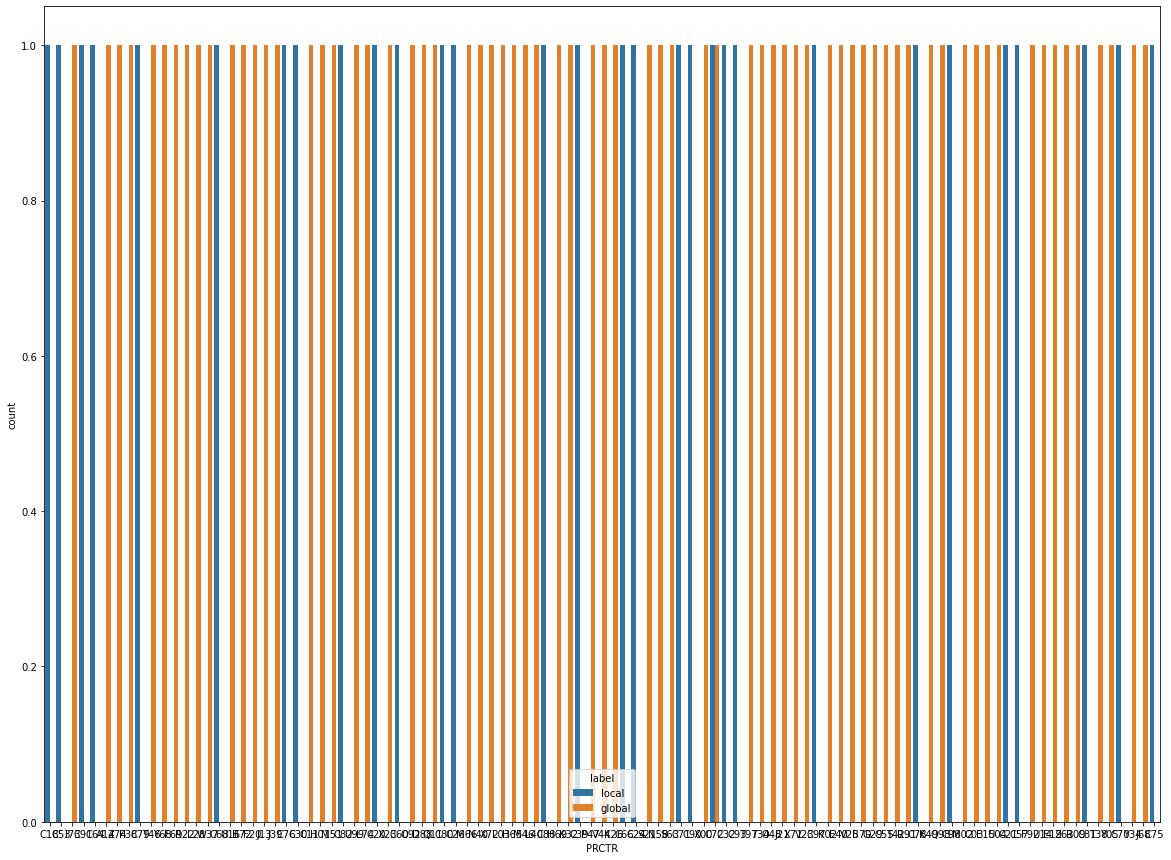

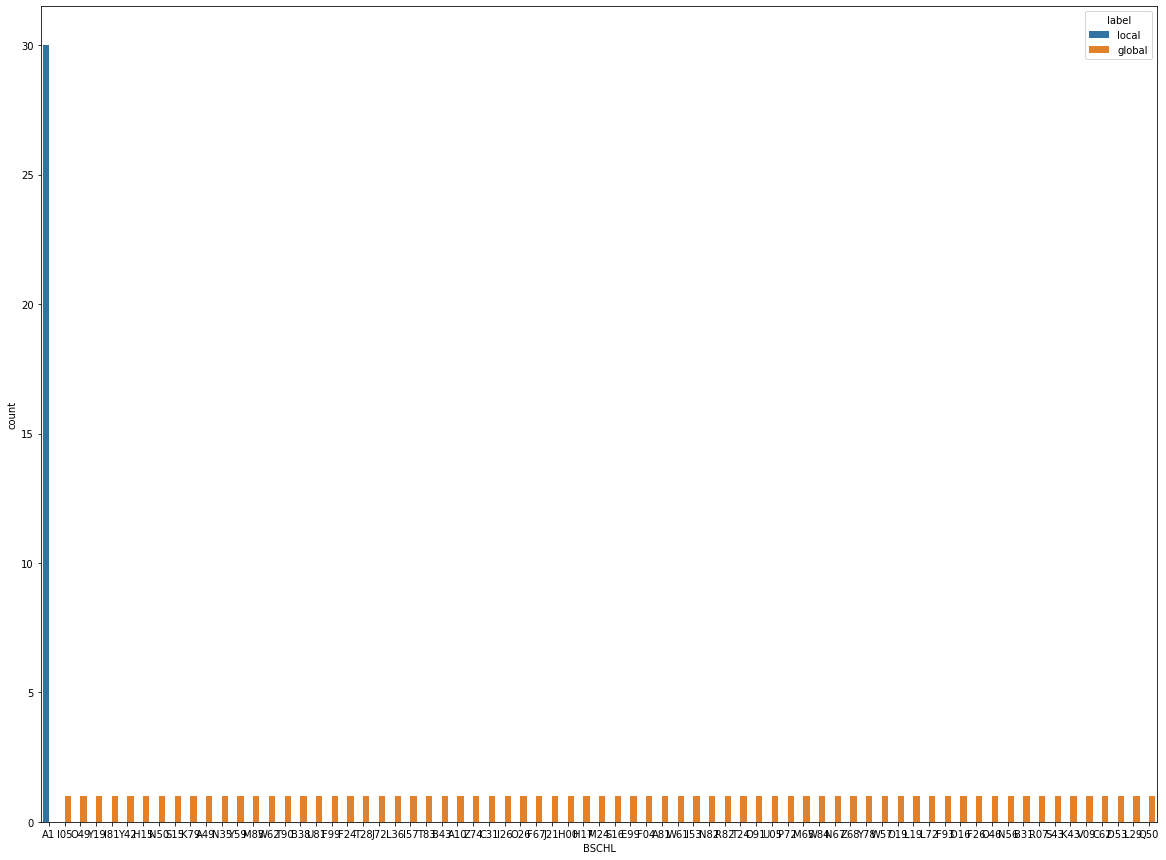

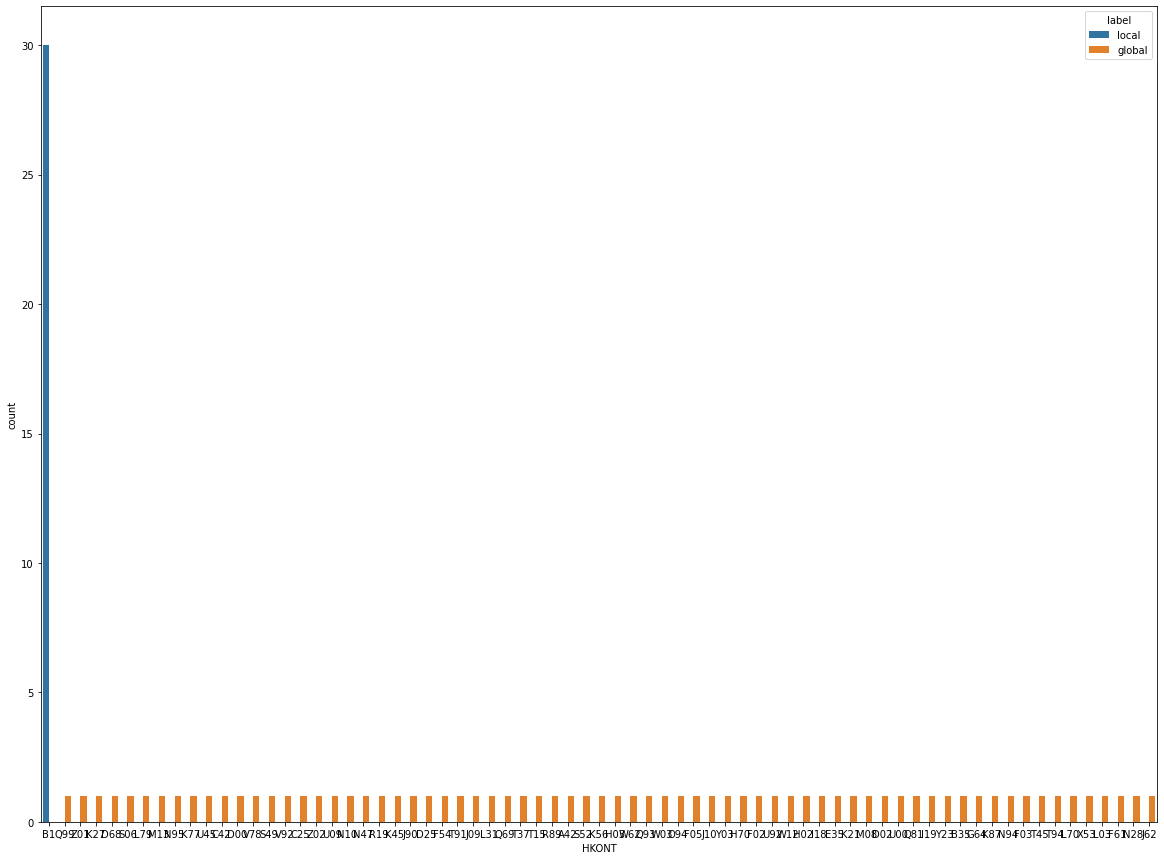

In [43]:
for col in categorical_variables.columns:
    sns.countplot(x=col, hue='label', data=df[(df['label']=='global')|(df['label']=='local')])
    plt.show()

In [44]:
for col in categorical_variables.columns:
    print(col)
    print(df.groupby('label')[col].agg(['count', 'nunique']))
    print('\n')

WAERS
          count  nunique
label                   
global       70       67
local        30        1
regular  532909        9


BUKRS
          count  nunique
label                   
global       70       70
local        30        3
regular  532909       90


KTOSL
          count  nunique
label                   
global       70       70
local        30        1
regular  532909        9


PRCTR
          count  nunique
label                   
global       70       70
local        30       30
regular  532909       90


BSCHL
          count  nunique
label                   
global       70       70
local        30        1
regular  532909        3


HKONT
          count  nunique
label                   
global       70       70
local        30        1
regular  532909        3




global anomalies are very distributed across categorical variables, while local anomalies seem tend to be confined only to few ones.

In [45]:
transformed_df = transformed_df.join(df['label'], on='BELNR')

<AxesSubplot:xlabel='WRBTR', ylabel='Count'>

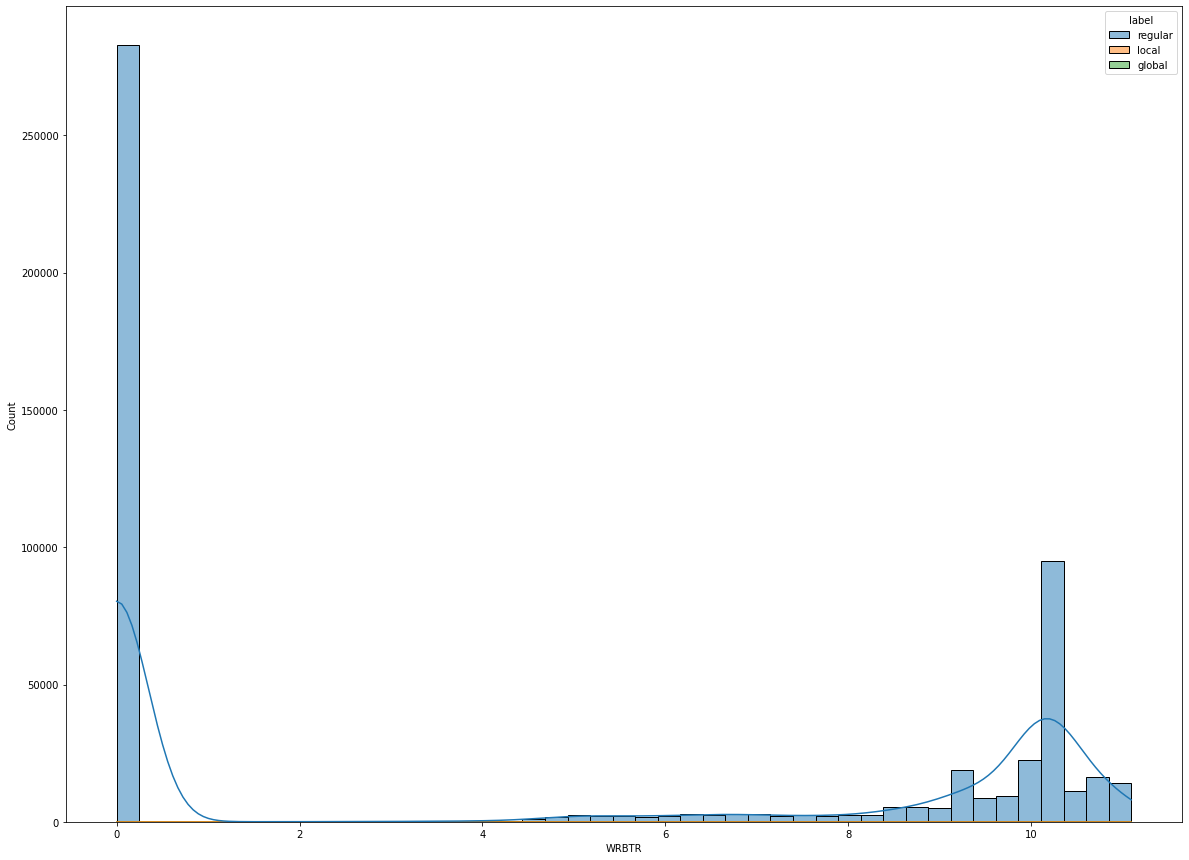

In [46]:
sns.histplot(data=transformed_df, x='WRBTR', hue="label", kde=True)

<AxesSubplot:xlabel='DMBTR', ylabel='Count'>

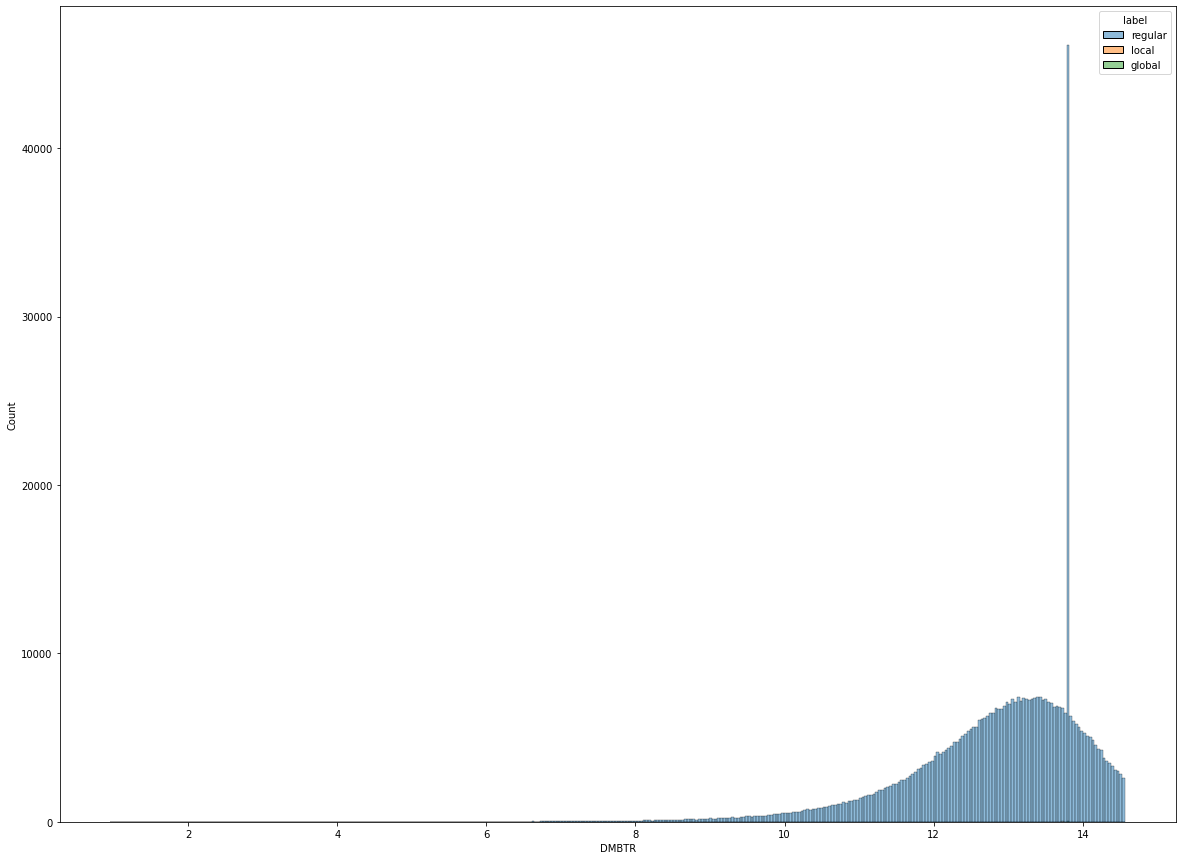

In [47]:
sns.histplot(data=transformed_df, x='DMBTR', hue="label")

In [48]:
df.shape

(533009, 9)

Anomaly values have very distinctive values, when compared to regular values. Removing low representative categorical variables lables may have impact by removing anomalies.
Also this an highly unbalanced dataset (100 anomalies in 533009 samples). Some ways to deal with it:
- Oversampling Techniques (SMOT)
- Undersampling Techniques
- Atribute a weighting factor according to the amount of the variables (class weighting).

Since Undersampling is not the preferred way since we'll lose loads of data points, let's try to compare both SMOT (may strugle due to the low representativity of the anomalous class) and class weighting.
Neural Networks also have mechanisms that helps dealing with unbalanced and hard examples, such as the Sigmoid Focal Loss.

### Data Preparation

Let's take care of: 
- the categorical encodings or 'bucketing'*;
- labels:
    - integer or one hot encoding;
    - compute class weights.
- Oversampling
- feature engineering if needed;
- SMOT technique.
- Split Data into Train and Test
- Scalling

(We already took care of the continuous variables part before)

Applying one hot encoding to several categorial features values will exponencily increase the sparsity in our dataset, which is not good for several ML models. Besides, methods such as PCA won't be helpful, once they only apply to continuous and correlated targets. Let's try alternative encoding options.

*bucketing consists on aggregatting categorical variables values on less (more general) ones, to be able to perform alternative sparser encondings (ex: one hot encoding).

In [49]:
# Encode Target
transformed_df_w_encoded_labels = transformed_df.replace({'label': {'regular': 0, 'local': 1, 'global': 1}})

In [50]:
transformed_final_df = categorical_variables.merge(transformed_df_w_encoded_labels, on='BELNR')

In [51]:
# So let's split the target from the predictor variables
y = transformed_final_df['label']
X = transformed_final_df.drop('label', axis=1)

In [52]:
X.head()

,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR
BELNR,,,,,,,,
288203,C3,C31,C9,C92,A3,B1,12.546037,0.000000
324441,C1,C18,C7,C76,A1,B2,11.774186,10.177932
133537,C1,C19,C2,C20,A1,B3,13.772043,10.177932
331521,C4,C48,C9,C95,A2,B1,13.790457,10.267366
375333,C5,C58,C1,C19,A3,B1,13.721765,5.846439


### Scalling

Some ML/DL Models require predictor data to be scalled between [0,1], or [-1,1]. For this experiment, since we're dealing with strict positive data, it may be helpful to scale data between 0 and 1 (Default value of MinMaxScaler). For a matter of convenience I don't usually scale target data (unless dealing with time series data and Neural Networks), to prevent me to do unnecessary transformations that could imply lead information leaks. Before performing scalling operations we need to split the data in train and test, to make sure we don't contaminate test data with information we've seen before.
- Pipeline Usage: For sklearn models I'll use pipelines for directly applying the scalling operations and, due to the simplicity for deployment.
- Neural Networks: Although there are Keras wrappers to train Neural Networks along with sklearn functions, I'll do the preparation the traditional way (Train Test split and Scale data)

In [53]:
seed=42
X_train_nn, X_test_and_val_nn, y_train_nn, y_test_and_val_nn = train_test_split(X, 
                                                                                y, 
                                                                                test_size=0.35, 
                                                                                random_state=seed, 
                                                                                stratify=y)

X_val_nn, X_test_nn, y_val_nn, y_test_nn = train_test_split(X_test_and_val_nn,
                                                            y_test_and_val_nn, 
                                                            test_size=0.5, 
                                                            random_state=seed, 
                                                            stratify=y_test_and_val_nn)

In [54]:
print(f'{X_train_nn.shape}, {X_val_nn.shape}, {X_test_nn.shape}')

(346455, 8), (93277, 8), (93277, 8)


In [55]:
print(f'{len(y_train_nn[y_train_nn==1])}, {len(y_val_nn[y_val_nn==1])}, {len(y_test_nn[y_test_nn==1])}')

65, 18, 17


In [56]:
def compute_class_weights(y):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    class_weights = dict(enumerate(class_weights))
    print(class_weights)
    
    return class_weights

class_weights = compute_class_weights(y_train_nn)

{0: 0.5000938248794711, 1: 2665.0384615384614}


In [57]:
def encode_categorical(X_train, X_val, X_test, y_train, y_val, y_test, categorical_variables_lst=list(categorical_variables.columns)):
        
        for col in X_train[categorical_variables_lst].columns:
            
            encoder = LeaveOneOutEncoder()
            
            train_encoder = encoder.fit_transform(X_train[[col]], y_train)
            val_encoder = encoder.fit_transform(X_val[[col]], y_val)
            test_encoder = encoder.fit_transform(X_test[[col]], y_test)

            X_train[col] = encoder.fit_transform(train_encoder, y_train)
            X_val[col] = encoder.fit_transform(val_encoder, y_val)
            X_test[col] = encoder.fit_transform(test_encoder, y_test)

        return X_train, X_val, X_test

In [58]:
X_train_nn, X_val_nn, X_test_nn = encode_categorical(X_train_nn, X_val_nn, X_test_nn, y_train_nn, y_val_nn, y_test_nn)

In [59]:
scaler = MinMaxScaler()
scaler.fit(X_train_nn)
X_train_nn = scaler.transform(X_train_nn)
X_val_nn = scaler.transform(X_val_nn)
X_test_nn = scaler.transform(X_test_nn)

## Modeling Phase

Time to train some models. Let's start from more interpretable and explainable ones, and progressively go to more complex ones.<br>
Logistic Regression, Naive Bayes Binary Classifier, Knn, Linear SVM (Less computational intensive due to the linear kernel) for binary classification seems a good starting point;
Also Decision Trees (Ensemble Methods such as Random Forest, Bagging or Boosting) may be interesting due to the high amounts of categorical data. Let's test also test some Neural Network architectures!
<br>
<br>
Note: Since I didn't perform any oversampling techinques, I will only use models that accept 'class_weight' as an argument.

In [60]:
# In order to save work, I created a class that allows to train the model and, to obtain the 
# most important metrics, according to the current problem.

class ModelGoestoGym:
    def __init__(self, model, X, y, categorical_variables_lst=list(categorical_variables.columns), seed=42):
        self.model = model
        self.X = X
        self.y = y
        self.categorical_variables_lst = categorical_variables_lst
        self.seed = seed
    
    # Method to encode categorical str/char to float
    # Since Label Encoding takes into the account the amount of the target feature
    # this method will be used everytime we generate a stratified Kfold batch
    def encode_categorical(self, X_train, X_test, y_train, y_test):
        for col in self.X[categorical_variables_lst].columns:
            encoder = LeaveOneOutEncoder()
            train_encoder = encoder.fit_transform(X_train[[col]], y_train)
            test_encoder = encoder.fit_transform(X_test[[col]], y_test)

            X_train[col] = encoder.fit_transform(train_encoder, y_train)
            X_test[col] = encoder.fit_transform(test_encoder, y_test)

        return X_train, X_test
        
    def train_model(self):
        # Cross Validation is a usefull method to see how robust our model is (helpful to check overfitting)
        # Stratified Kfold guarantees that the target (label) maintains it's proportions while changing fold
        # In this case our cross validation method will split our dataset in 5 folds
        stratified_cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=self.seed)
        
        history_auc = []
        history_auprc = []
        history_precision = []
        history_recall = []
        history_f1_sc = []
        history_conf_matrixes = []
        for train_index, test_index in stratified_cv.split(self.X, self.y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Label Encode the categorical features in the dataset
            X_train, self.X_test = self.encode_categorical(X_train, X_test, y_train, y_test)
            
            # Make a pipeline to ensure that features are scalled between [0,1] 
            clf = make_pipeline(MinMaxScaler(), self.model)
            # Fit the model
            clf = clf.fit(X_train, y_train)
            
            # Inference
            y_pred = clf.predict(X_test)
            
            # Get and store the metrics for the evaluation phase 
            auc, auprc, precision, recall, f1_sc, cnf_mat = self.evaluate_model(clf, X_test, y_test, y_pred)
            
            history_auc.append(auc)
            history_auprc.append(auprc)
            history_precision.append(precision)
            history_recall.append(recall)
            history_f1_sc.append(f1_sc)
            history_conf_matrixes.append(cnf_mat)
        
        self.history = [history_auc, history_precision, history_recall, history_f1_sc]
        
        return history_auc, history_auprc, history_precision, history_recall, history_f1_sc, history_conf_matrixes
    
    # Call this to evaluate the unbalanced model
    def evaluate_model(self, clf, X_test, y_true, y_pred, avg='macro'):
        auc = roc_auc_score(y_true, y_pred, average=avg)
        auprc = average_precision_score(y_true, y_pred, average=avg)
        precision = precision_score(y_true, y_pred, average=avg)
        recall = recall_score(y_true, y_pred, average=avg)
        f1_sc = f1_score(y_true, y_pred, average=avg)
        cnf_matrix = confusion_matrix(y_true, y_pred)
        
        return auc, auprc, precision, recall, f1_sc, cnf_matrix
    
    # Call this to show the average value of the metrics appended in the cross validation
    def show_avg_results(self):
        metrics_lst = ['AUC', 'AUCPRC','precision','recall','f1 score']
        for i in range(len(self.history)):
            print(f'Mean {metrics_lst[i]} ----> {np.mean(self.history[i])}')

#### Logistic Regression

In [61]:
categorical_variables_lst = list(categorical_variables.columns)

# Create Model Instance
log_reg_model = ModelGoestoGym(LogisticRegression(class_weight=class_weights, random_state=seed), 
                               X, 
                               y, 
                               categorical_variables_lst)

log_reg_auc, log_reg_auprc, log_reg_precision, log_reg_recall, log_reg_f1_sc, log_reg_conf_matrix = log_reg_model.train_model()

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)


/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)


/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)


/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)


In [62]:
log_reg_model.show_avg_results()

Mean AUC ----> 0.9776289304635555
Mean AUCPRC ----> 0.5121985405710736
Mean precision ----> 0.9776289304635555
Mean recall ----> 0.5169933280975616


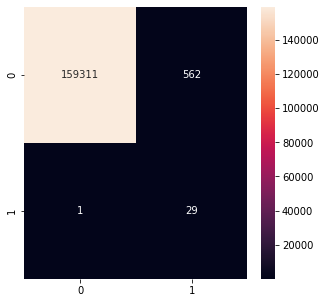

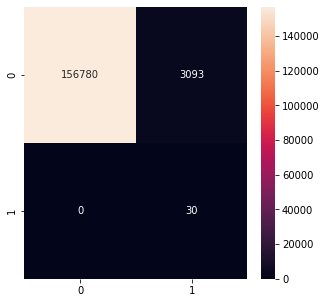

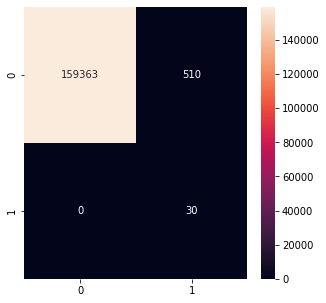

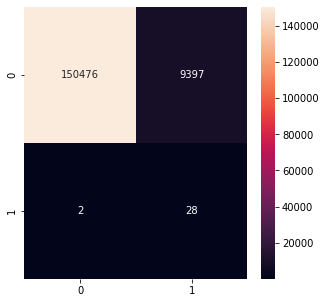

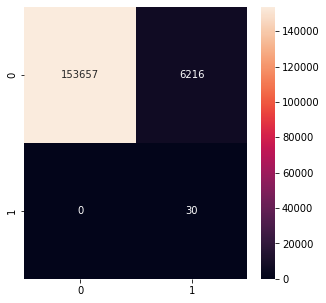

In [63]:
def plot_conf_matrix(model_conf_matrix):
    for matrix in model_conf_matrix:
        plt.figure(figsize=(5,5))
        sns.heatmap(matrix, annot=True, fmt='d')
        plt.show()
        
plot_conf_matrix(log_reg_conf_matrix)

#### Linear SVM

In [64]:
# Create Model Instance
svm_model = ModelGoestoGym(LinearSVC(class_weight=class_weights, random_state=seed), 
                           X, y,
                           categorical_variables_lst)

# Train Model
svm_auc, svm_auprc, svm_precision, svm_recall, svm_f1_sc, svm_conf_matrix = svm_model.train_model()

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a 

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(train_encoder, y_train)
/var/folders/5b/6_f92g2j55d2_r2ksc3lxy340000gn/T/ipykernel_4180/794109393.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(test_encoder, y_test)
/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to

In [65]:
svm_model.show_avg_results()

Mean AUC ----> 0.9792894985394657
Mean AUCPRC ----> 0.5380085075784159
Mean precision ----> 0.9792894985394657
Mean recall ----> 0.5643385547951887


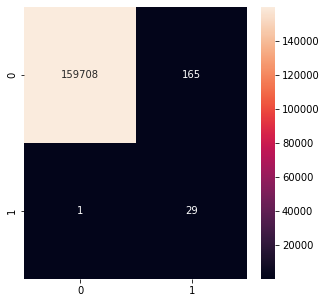

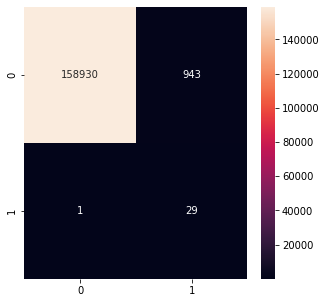

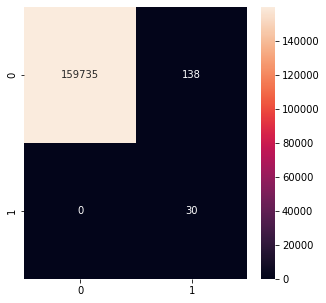

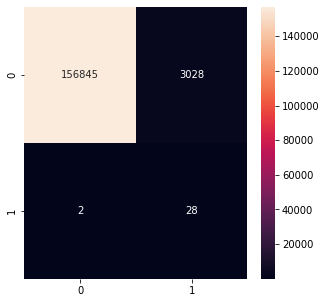

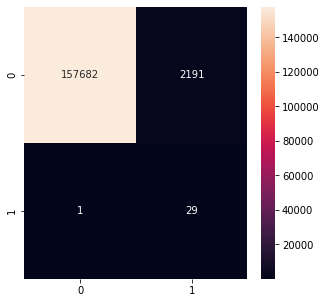

In [66]:
plot_conf_matrix(svm_conf_matrix)

#### Random Forest

In [67]:
# Create Model Instance
# random_forest_model = ModelGoestoGym(RandomForestClassifier(class_weight=class_weights, 
#                                                             random_state=seed,
#                                                             max_features='sqrt',
#                                                             max_depth=5), 
#                                        X, y,
#                                        categorical_variables_lst)

# # Train Model
# rf_accuracy, rf_precision, rf_recall, rf_f1_sc, rf_conf_matrix = random_forest_model.train_model()

#### XGB

In [68]:
# Create Model Instance
# xgb_model = ModelGoestoGym(xgb.XGBClassifier(class_weight=class_weights), 
#                                      X, y,
#                                      categorical_variables_lst)

# # Train Model
# xgb_accuracy, xgb_precision, xgb_recall, xgb_f1_sc, xgb_conf_matrix = xgb_model.train_model()

In [69]:
# xgb_model.show_avg_results()

#### LightGBM

In [70]:
# Create Model Instance
#light_gbm_model = ModelGoestoGym(lgb.LGBMClassifier(class_weight=class_weights, random_state=seed), 
#                                                     X, y,
#                                                     categorical_variables_lst)

# Train Model
#lgbm_accuracy, lgbm_precision, lgbm_recall, lgbm_f1_sc, lgbm_conf_matrix = light_gbm_model.train_model()

In [71]:
#light_gbm_model.show_avg_results()

In [72]:
#plot_conf_matrix(lgbm_conf_matrix)

#### Neural Network (Simple Feedforward ANN)

In [73]:
# plot confusion matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [103]:
def plot_metrics(history):
    metrics = ['auc', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 linestyle="--", label='Val')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1.2])
        else:
            plt.ylim([0,1.1])

In [75]:
input_layer = Input(shape=(X_train_nn.shape[1],))
dense_1 = Dense(256, activation='relu')(input_layer)
dpout_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(512, activation='relu')(dpout_1)
dpout_2 = Dropout(0.2)(dense_2)
dense_3 = Dense(512, activation='relu')(dpout_2)
dpout_3 = Dropout(0.2)(dense_3)
dense_4 = Dense(1024, activation='relu')(dpout_3)
dpout_4 = Dropout(0.25)(dense_4)
dense_6 = Dense(2048, activation='relu')(dpout_4)
dpout_6 = Dropout(0.3)(dense_6)
output_layer = Dense(1, activation='sigmoid')(dpout_6)
fann_model = Model(inputs=input_layer, outputs=output_layer)

Metal device set to: Apple M1


2022-08-04 14:53:00.771208: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-04 14:53:00.771291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [76]:
def step_decay(epoch):
    initial_lrate = 1e-4
    drop = 0.1
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    
    return lrate

scheduler = tensorflow.keras.callbacks.LearningRateScheduler(step_decay)

In [77]:
fann_model.compile(
              optimizer=Adam(), 
              loss=tfa.losses.SigmoidFocalCrossEntropy(),
              metrics=[tensorflow.keras.metrics.Precision(name='precision'), 
                       tensorflow.keras.metrics.Recall(name='recall'),
                       tensorflow.keras.metrics.AUC(name='prc', curve='PR'),
                       tensorflow.keras.metrics.AUC(name='auc')])

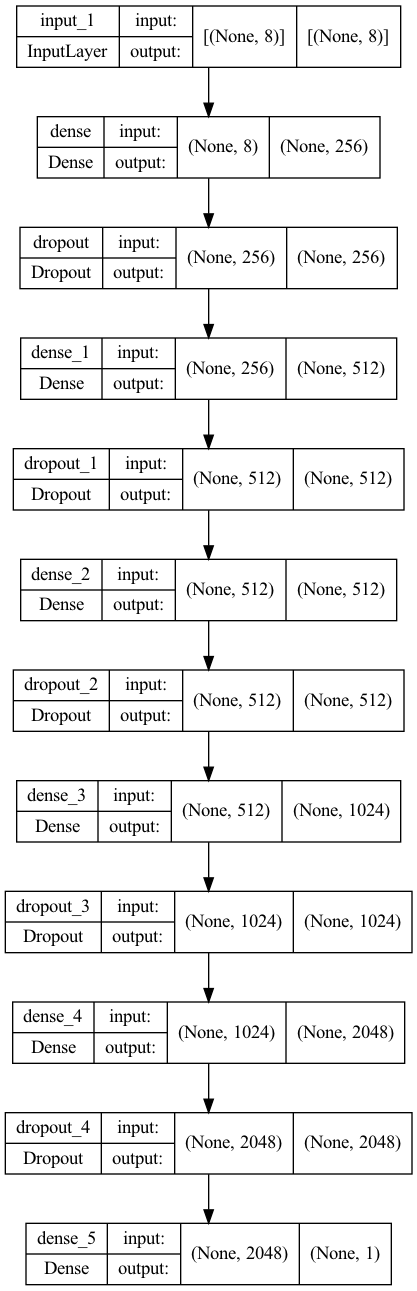

In [78]:
plot_model(fann_model, show_shapes=True)

In [79]:
earlystopping = callbacks.EarlyStopping(monitor ="val_prc",
                                        mode ="max", 
                                        patience = 10, 
                                        restore_best_weights=True)

In [80]:
BATCH_SIZE=1024

fann_hist = fann_model.fit(X_train_nn, 
                y_train_nn,
                batch_size = BATCH_SIZE,
                epochs = 500,
                callbacks=[earlystopping, scheduler],
                validation_data=(X_val_nn, y_val_nn),
                class_weight=class_weights)

Epoch 1/500


2022-08-04 14:53:01.141960: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-04 14:53:01.756937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


339/339 [==============================] - ETA: 0s - loss: 0.0600 - precision: 0.0034 - recall: 0.4769 - prc: 0.0634 - auc: 0.8799

2022-08-04 14:53:13.235112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


339/339 [==============================] - 14s 37ms/step - loss: 0.0600 - precision: 0.0034 - recall: 0.4769 - prc: 0.0634 - auc: 0.8799 - val_loss: 0.0103 - val_precision: 0.0083 - val_recall: 1.0000 - val_prc: 0.7273 - val_auc: 0.9975 - lr: 1.0000e-04
Epoch 2/500
339/339 [==============================] - 13s 37ms/step - loss: 0.0239 - precision: 0.0029 - recall: 0.8923 - prc: 0.0191 - auc: 0.9797 - val_loss: 0.0143 - val_precision: 0.0070 - val_recall: 1.0000 - val_prc: 0.7277 - val_auc: 0.9977 - lr: 1.0000e-04
Epoch 3/500
339/339 [==============================] - 14s 41ms/step - loss: 0.0256 - precision: 0.0051 - recall: 0.9385 - prc: 0.1771 - auc: 0.9821 - val_loss: 0.0072 - val_precision: 0.0136 - val_recall: 1.0000 - val_prc: 0.7292 - val_auc: 0.9982 - lr: 1.0000e-04
Epoch 4/500
339/339 [==============================] - 14s 43ms/step - loss: 0.0242 - precision: 0.0079 - recall: 0.9538 - prc: 0.2432 - auc: 0.9839 - val_loss: 0.0212 - val_precision: 0.0074 - val_recall: 1.0000 -

In [81]:
fann_model.evaluate(X_test_nn, y_test_nn, BATCH_SIZE)

92/92 [==============================] - 2s 19ms/step - loss: 0.0053 - precision: 0.8947 - recall: 1.0000 - prc: 1.0000 - auc: 1.0000


[0.0052519612945616245, 0.8947368264198303, 1.0, 1.0, 1.0000001192092896]

In [82]:
y_pred = fann_model.predict(X_test_nn)

2022-08-04 15:00:21.480540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


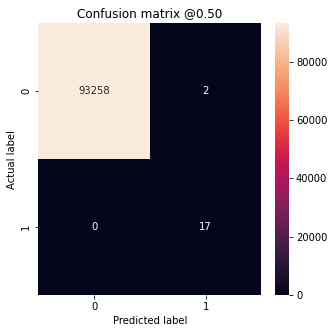

In [83]:
plot_cm(y_test_nn, y_pred)

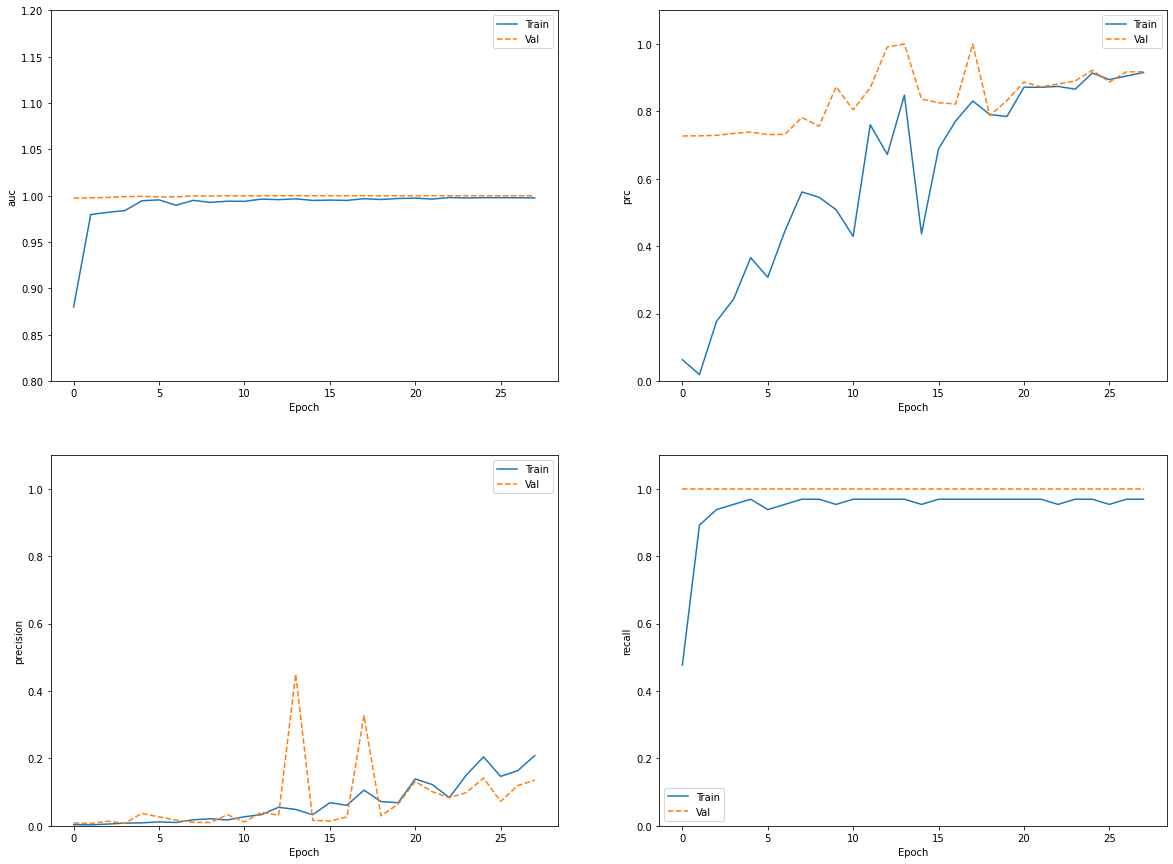

In [104]:
plot_metrics(fann_hist)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


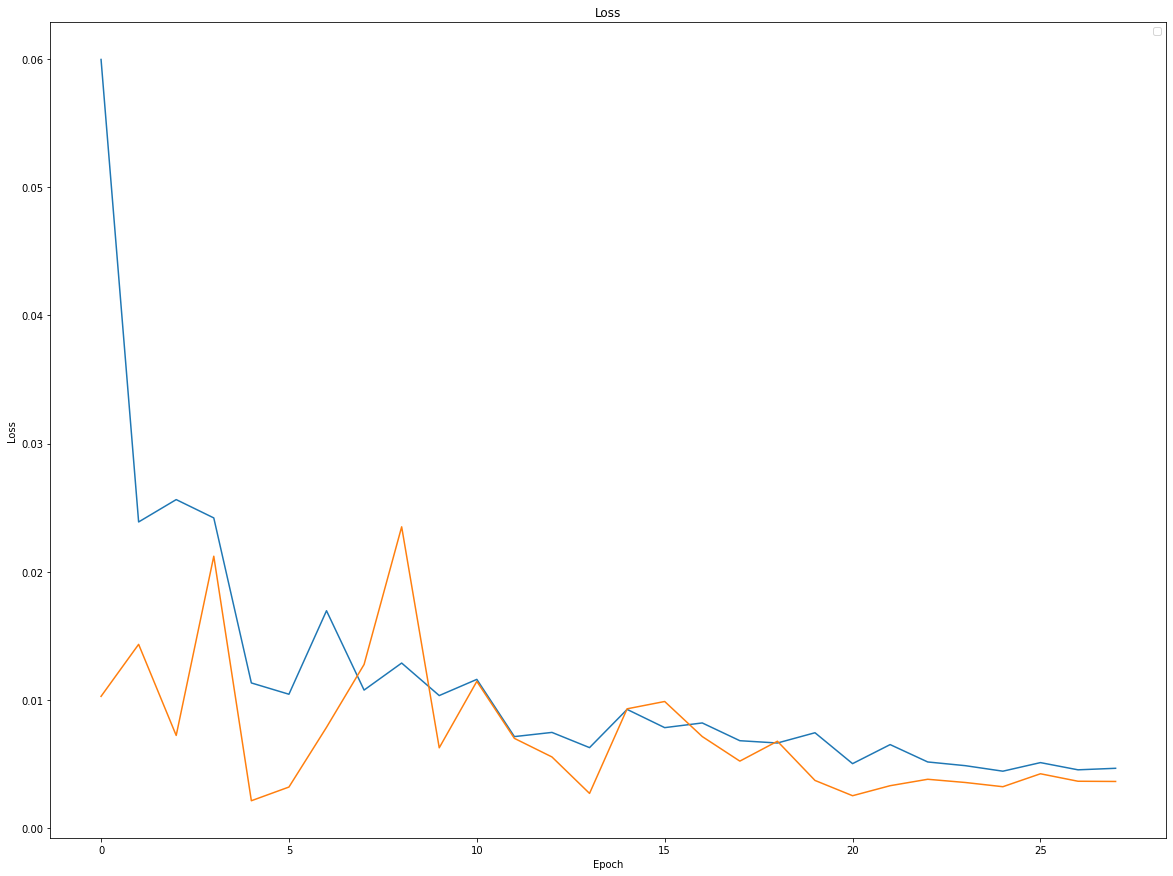

In [107]:
plt.plot(fann_hist.history['loss'])
plt.plot(fann_hist.history['val_loss'])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

#### Neural Network Based on 1D Convolutions Architecture

In [108]:
X_train_cnn = np.reshape(X_train_nn,(X_train_nn.shape[0], X_train_nn.shape[1], 1))
X_val_cnn = np.reshape(X_val_nn,(X_val_nn.shape[0], X_val_nn.shape[1], 1))
X_test_cnn = np.reshape(X_test_nn,(X_test_nn.shape[0], X_test_nn.shape[1], 1))

In [109]:
cnn_input = Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))

conv_layer_1 = Conv1D(filters=128, 
                    kernel_size=3,
                    strides=1, 
                    padding="same", 
                    activation='relu')(cnn_input)

pooling_layer_1 = MaxPooling1D(pool_size=2)(conv_layer_1)
dpout_pooling_1 = Dropout(0.2)(pooling_layer_1)

conv_layer_2 = Conv1D(filters=256, 
                    kernel_size=3,
                    strides=1,
                    padding="same", 
                    activation='relu')(dpout_pooling_1)

pooling_layer_2 = MaxPooling1D(pool_size=2)(conv_layer_2)
dpout_pooling_2 = Dropout(0.2)(pooling_layer_2)

flatten_layer = Flatten()(dpout_pooling_2)

dense_5 = Dense(2048, activation='relu')(flatten_layer)
dpout_5 = Dropout(0.25)(dense_5)
dense_6 = Dense(512, activation='relu')(dpout_5)
dpout_6 = Dropout(0.2)(dense_6)
dense_7 = Dense(256, activation='relu')(dpout_6)
dpout_7 = Dropout(0.2)(dense_7)

output_layer = Dense(1, activation='sigmoid')(dpout_7)

cnn_model = Model(inputs=cnn_input, outputs=output_layer)

In [110]:
cnn_model.compile(
              optimizer=Adam(), 
              loss=tfa.losses.SigmoidFocalCrossEntropy(),
              metrics=[tensorflow.keras.metrics.Precision(name='precision'), 
                       tensorflow.keras.metrics.Recall(name='recall'),
                       tensorflow.keras.metrics.AUC(name='prc', curve='PR'),
                       tensorflow.keras.metrics.AUC(name='auc')])

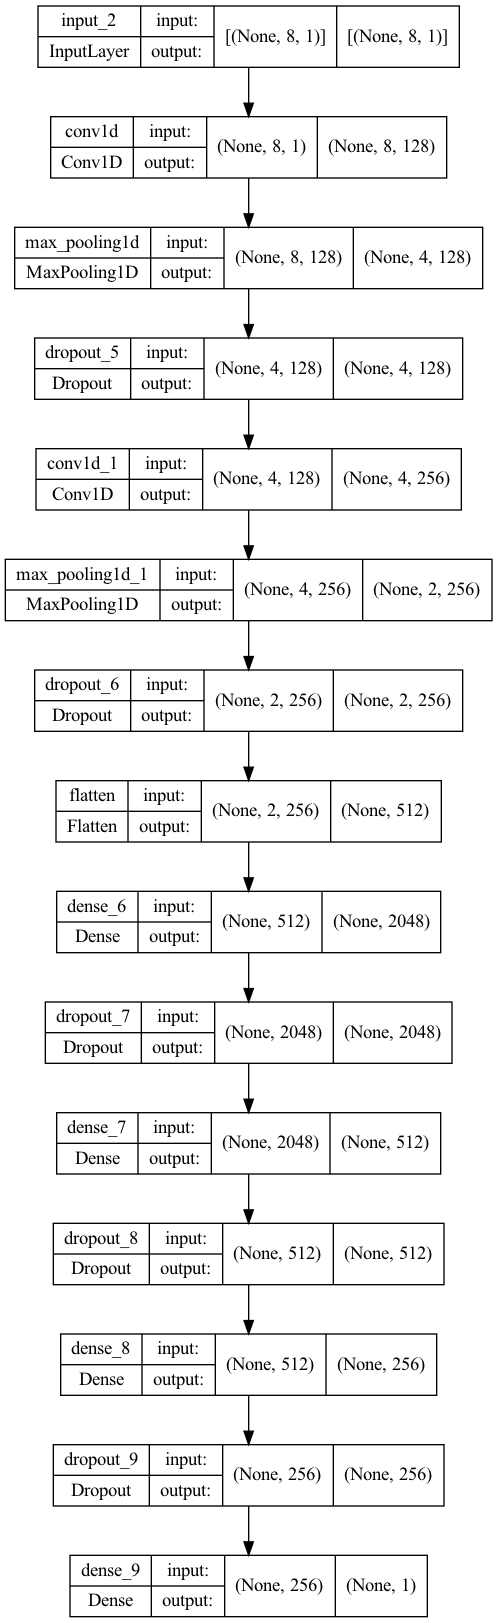

In [111]:
plot_model(cnn_model, show_shapes=True)

In [112]:
cnn_hist = cnn_model.fit(X_train_cnn, 
                y_train_nn,
                batch_size = BATCH_SIZE,
                epochs = 500,
                callbacks=[earlystopping, scheduler],
                validation_data=(X_val_cnn, y_val_nn),
                class_weight=class_weights)

Epoch 1/500


2022-08-04 15:10:59.413842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


339/339 [==============================] - ETA: 0s - loss: 0.0526 - precision: 0.0174 - recall: 0.3846 - prc: 0.0275 - auc: 0.8772

2022-08-04 15:11:15.794791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


339/339 [==============================] - 19s 52ms/step - loss: 0.0526 - precision: 0.0174 - recall: 0.3846 - prc: 0.0275 - auc: 0.8772 - val_loss: 0.0426 - val_precision: 0.0010 - val_recall: 1.0000 - val_prc: 0.7258 - val_auc: 0.9965 - lr: 1.0000e-04
Epoch 2/500
339/339 [==============================] - 17s 50ms/step - loss: 0.0158 - precision: 0.0057 - recall: 0.9385 - prc: 0.0406 - auc: 0.9892 - val_loss: 0.0158 - val_precision: 0.0048 - val_recall: 1.0000 - val_prc: 0.6283 - val_auc: 0.9955 - lr: 1.0000e-04
Epoch 3/500
339/339 [==============================] - 17s 51ms/step - loss: 0.0219 - precision: 0.0044 - recall: 0.8769 - prc: 0.0389 - auc: 0.9844 - val_loss: 0.0352 - val_precision: 0.0036 - val_recall: 1.0000 - val_prc: 0.7261 - val_auc: 0.9968 - lr: 1.0000e-04
Epoch 4/500
339/339 [==============================] - 17s 50ms/step - loss: 0.0190 - precision: 0.0056 - recall: 0.9538 - prc: 0.0377 - auc: 0.9881 - val_loss: 0.0233 - val_precision: 0.0048 - val_recall: 1.0000 -

In [113]:
cnn_model.evaluate(X_test_nn, y_test_nn, BATCH_SIZE)

2022-08-04 15:16:19.735550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 2s 20ms/step - loss: 0.0426 - precision: 0.0012 - recall: 1.0000 - prc: 0.7101 - auc: 0.9968


[0.04258374869823456,
 0.001207986962981522,
 1.0,
 0.710060179233551,
 0.9968289732933044]

In [114]:
y_pred = cnn_model.predict(X_test_cnn)

2022-08-04 15:16:21.864114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


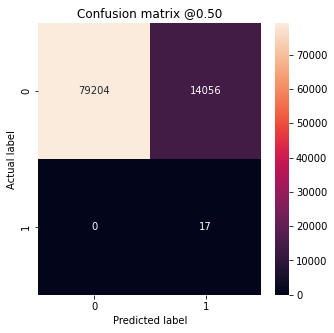

In [115]:
plot_cm(y_test_nn, y_pred)

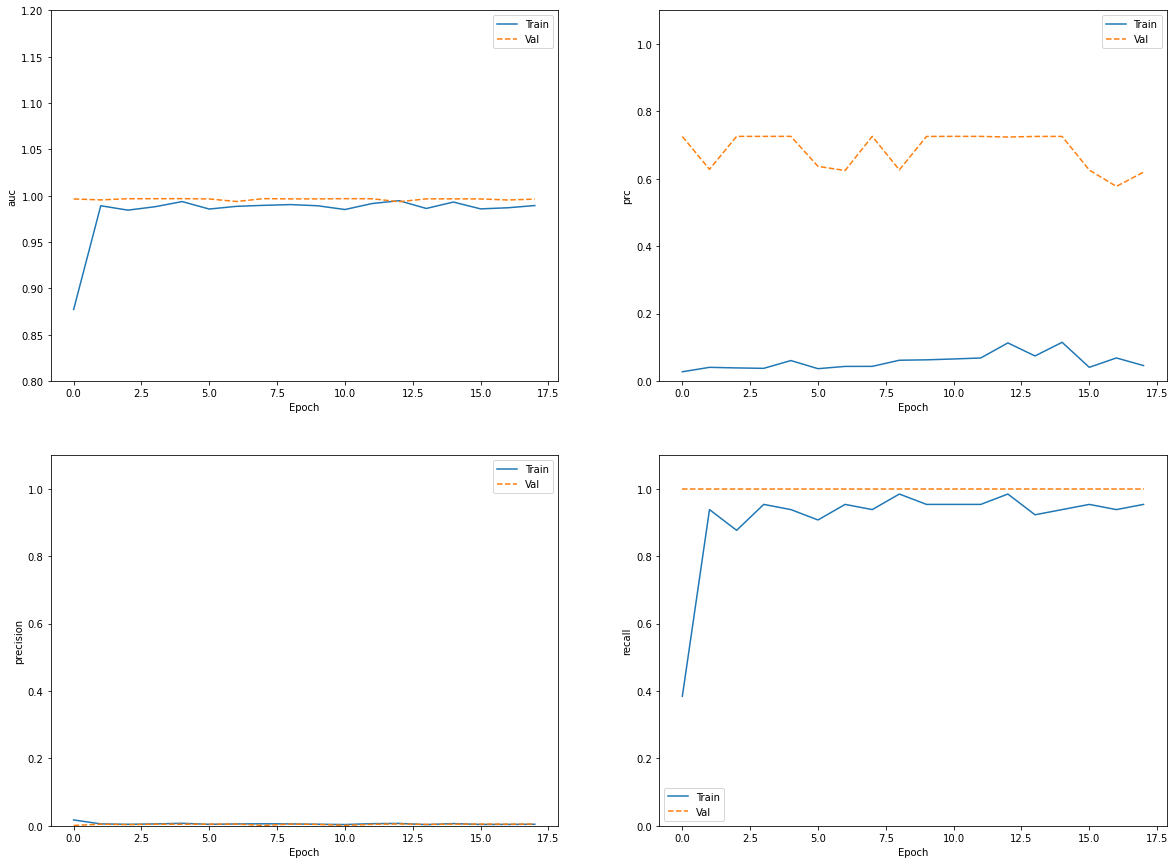

In [117]:
plot_metrics(cnn_hist)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


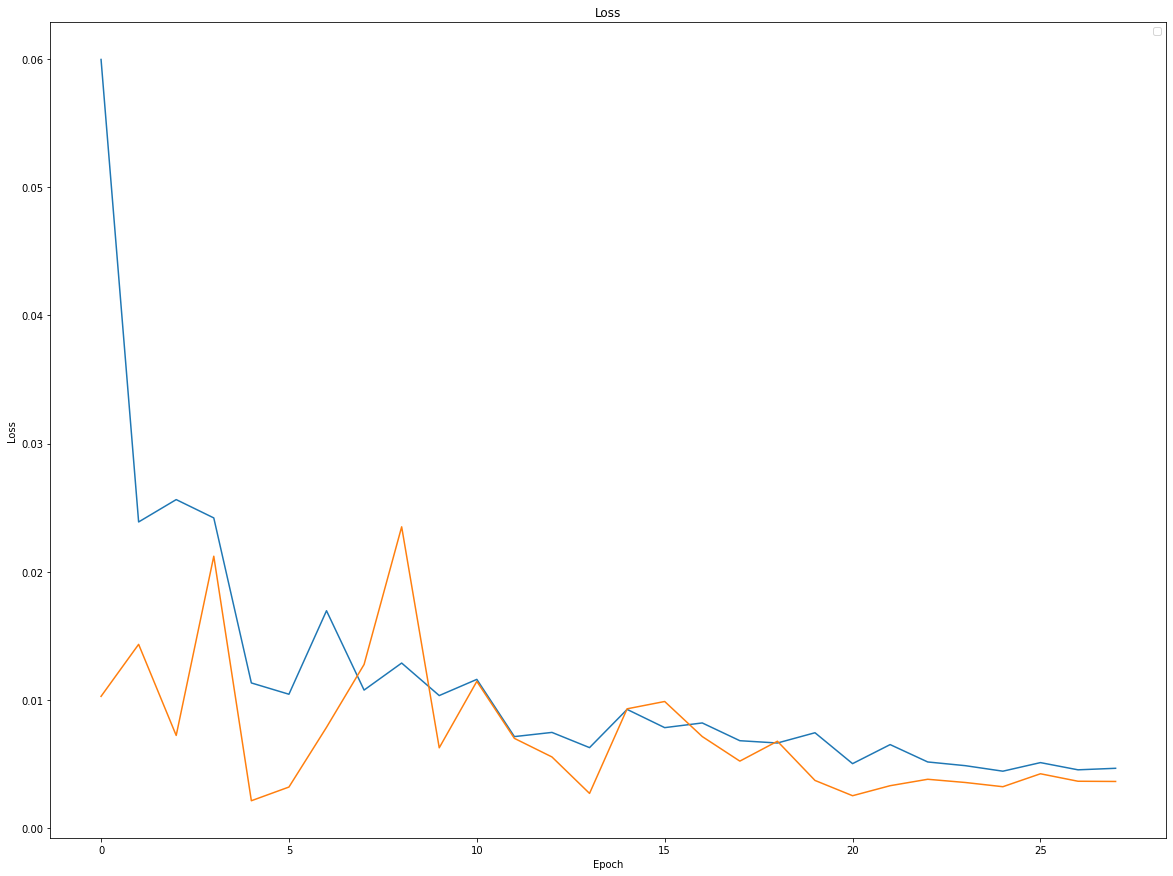

In [118]:
plt.plot(fann_hist.history['loss'])
plt.plot(fann_hist.history['val_loss'])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()